# chromatic_fitting

Add-on to the [chromatic](https://github.com/zkbt/chromatic) package to perform a simultaneous multi-wavelength transit fit

In [1]:
import chromatic
from chromatic import *
print("chromatic version = " + str(chromatic.version()))

chromatic version = 0.0.12


In [2]:
import pandas as pd
import numpy as np
import exoplanet as xo
import starry
from exotic_ld import limb_dark_fit
print("numpy version = " + str(np.__version__))
import theano
print("theano version = " + str(theano.__version__))
from astropy.constants import G
from astropy import units as u
import math
import pickle
import spectrum
from astropy.table import Table
# print(theano.config)

numpy version = 1.20.3
theano version = 1.1.2


## Import Patricio's multi-wavelength transit model:

In [3]:
x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
x.keys()

dict_keys(['units', 'NGTS10b_parameters', 'WASP39b_parameters', 'NGTS10b_MIRI', 'WASP39b_NIRCam', 'WASP39b_NIRSpec', 'WASP39b_NIRISS'])

Load in planetary spectrum classes from ZBT defined [here](https://github.com/ers-transit/ers-data-checkpoint-showcase/blob/main/features/playing-around-with-patricio-signals_Catriona_edits.ipynb) 

In [71]:
# lets load a model
planet = x['WASP39b_NIRSpec']
planet_params = x['WASP39b_parameters']

wavelength = planet['wl']
depth = planet['transmission']
table = Table(dict(wavelength=planet['wl'], depth=planet['transmission']), meta=planet_params)

model = spectrum.PlanetarySpectrumModel(table=table, label='injected model')

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

In [5]:
planet_params

{'cosi': 0.03786459100977565,
 'a_rs': 11.37,
 'period': 4.055259,
 'rstar': 62265150000.0,
 'LDC_niriss1': [0.0, 0.7373, 0.0, -0.2928],
 'LDC_niriss2': [0.0, 0.8253, 0.0, -0.2624],
 'LDC_nirspec': [0.0, 0.2379, 0.0, 0.4615],
 'LDC_nircam': [0.0, 0.2379, 0.0, 0.4615]}

In [72]:
print(np.shape(wavelength))

(500,)


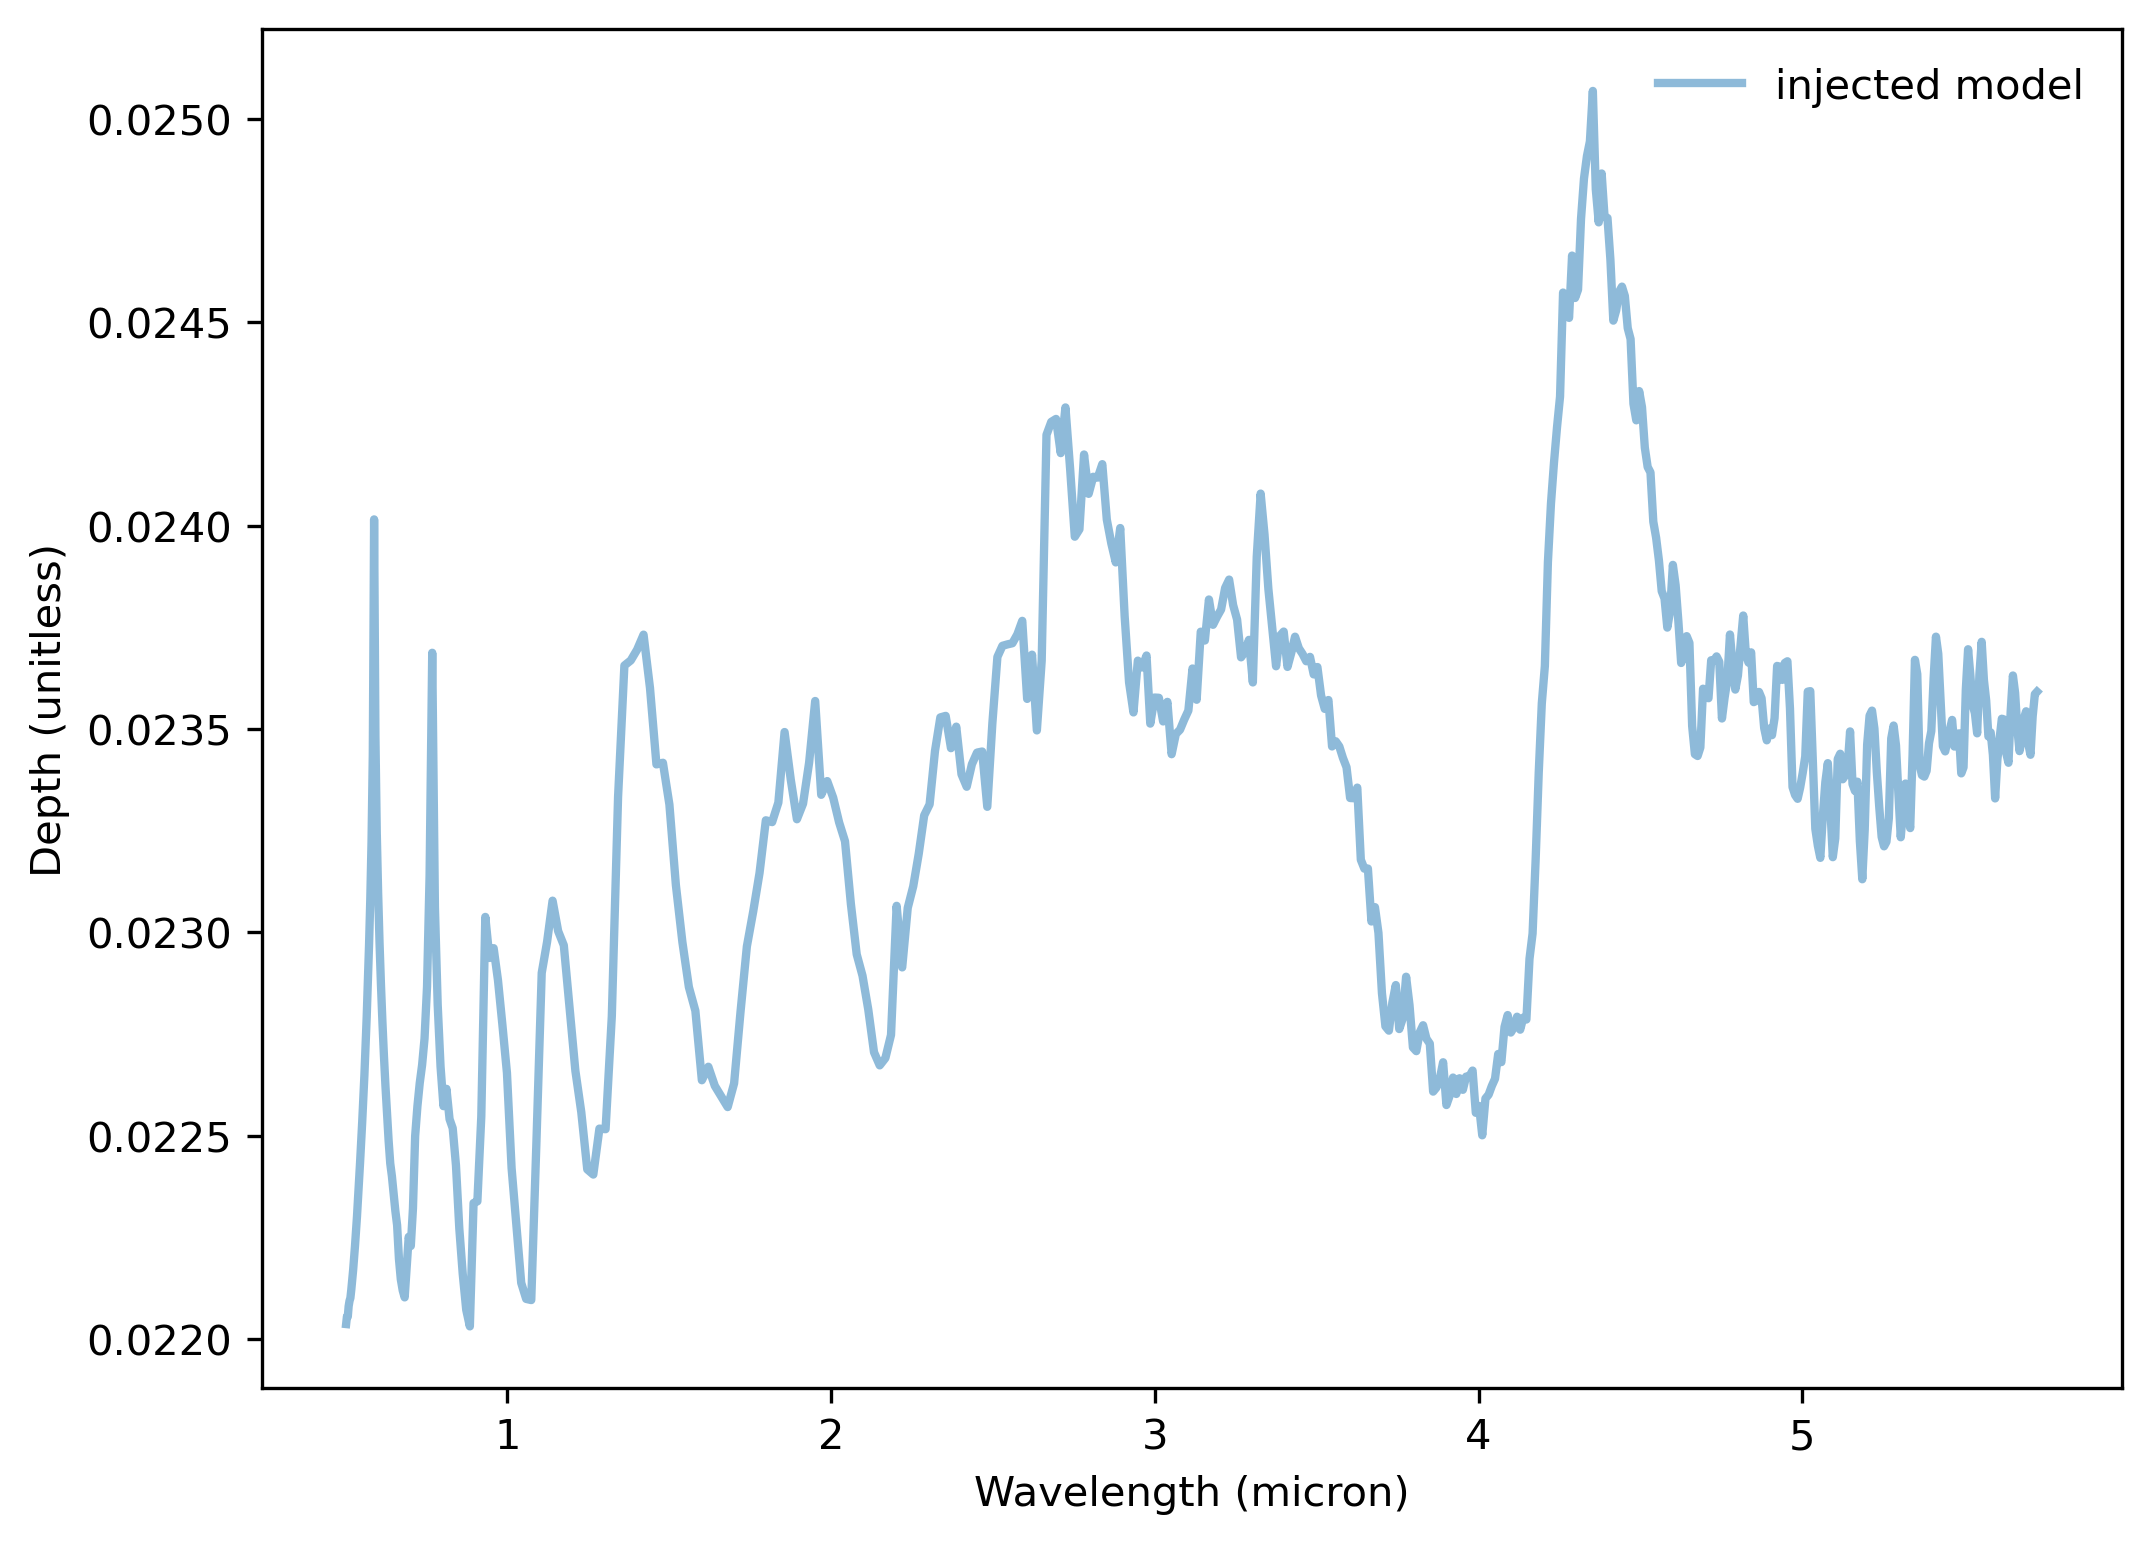

In [35]:
# print(wavelength)

# plot model to check everything's okay
ax = model.plot()
plt.legend(frameon=False);

In [77]:
# JWST NIRCam mode
mode = 'NIRCam_F322W2' # this mode only includes ~2.3-4.3 microns
ld_eqn = "quadratic"

# Set up the stellar parameters
M_H = -0.03
Teff = 5326.6
logg = 4.38933

# Tell it where the data from the Zenodo link has been placed
dirsen = '/Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data' 

# Tell it which stellar model grid you would like to use: '1D' or '3D'
ld_model = '1D'

# include an option to choose the linear, quadratic, 4-param or non-linear options
# (NOTE: There is a current issue open in ExoTiC to add a selection criteria so that only the desired coefficients are returned.)
ld_coeffs = [] 
wv_mean, wv_range, depth = [],[],[]

for w in range(len(wavelength)):
    if w>0 and w<len(wavelength)-1:
        wsdata = [wavelength[w]-(0.5*(wavelength[w]-wavelength[w-1])),wavelength[w]+(0.5*(wavelength[w+1]-wavelength[w]))]
    elif w==0:
        wsdata = [wavelength[w],wavelength[w]+0.5*(wavelength[w+1]-wavelength[w])]
    elif w==len(wavelength)-1:
        wsdata = [wavelength[w]-(0.5*(wavelength[w]-wavelength[w-1])),wavelength[w]]
#     wsdata = wavelength[w:w+2]
    print(10000*(wsdata[1]-wsdata[0]))
        
    print("Wavelength range: ", wsdata)
    # Use ExoTiC-LD to calculate wavelength-dependent LD coeffs
    result = limb_dark_fit(mode, np.array(wsdata)*10000, M_H, Teff, logg, dirsen, ld_model=ld_model)
        
    # If all zeros are returned then ignore
    if np.all(np.array(result)==0.0):
        print("Outside NIRCam wavelength range!\n")
    else:
        
        if ld_eqn=="linear":
            print("Using linear LD equation\n")
            ld_coeffs.append(result[0])
            wv_range.append(wsdata)
            wv_mean.append(np.mean(wsdata))
            depth.append(np.sqrt(planet['transmission'][w]))
                
        elif ld_eqn=="quadratic":
            print("Using quadratic LD equation\n")
            ld_coeffs.append(result[9:11])
            wv_range.append(wsdata)
            wv_mean.append(np.mean(wsdata))
            depth.append(np.sqrt(planet['transmission'][w]))
                
        elif ld_eqn=="nonlinear":
            print("Using non-linear LD equation\n")
            ld_coeffs.append(result[1:5])
            wv_range.append(wsdata)
            wv_mean.append(np.mean(wsdata))
            depth.append(np.sqrt(planet['transmission'][w]))
                
        elif ld_eqn=="threeparam":
            print("Using three-paramter LD equation\n")
            ld_coeffs.append(result[5:9])
            wv_range.append(wsdata)
            wv_mean.append(np.mean(wsdata))
            depth.append(np.sqrt(planet['transmission'][w]))
    
        else:
            print("No valid LD equation method chosen!\n")
            

12.706220149993896
Wavelength range:  [0.5025298595428467, 0.5038004815578461]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

25.769174098968506
Wavelength range:  [0.5038004815578461, 0.5063773989677429]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

26.178061962127686
Wavelength range:  [0.5063773989677429, 0.5089952051639557]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

26.574432849884033
Wavelength range:  [0.5089952051639557, 0.5116526484489441]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

27.020573616027832
Wavelength range:  [0.5116526484489441, 0.5143547058105469]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

27.416348457336426
Wavelength range:  [0.5143547058105469, 0.5170963406562805]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

27.891993522644043
Wavelength range:  [0.5170963406562805, 0.5198855400085449]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

28.294026851654053
Wavelength range:  [0.5198855400085449, 0.5227149426937103]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

28.799772262573242
Wavelength range:  [0.5227149426937103, 0.5255949199199677]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

29.22147512435913
Wavelength range:  [0.5255949199199677, 0.5285170674324036]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

29.744505882263184
Wavelength range:  [0.5285170674324036, 0.5314915180206299]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

30.726194381713867
Wavelength range:  [0.5345204174518585, 0.5375930368900299]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

31.31568431854248
Wavelength range:  [0.5375930368900299, 0.5407246053218842]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

31.811296939849854
Wavelength range:  [0.5407246053218842, 0.5439057350158691]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

32.36442804336548
Wavelength range:  [0.5439057350158691, 0.5471421778202057]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

33.00875425338745
Wavelength range:  [0.5471421778202057, 0.5504430532455444]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

33.512115478515625
Wavelength range:  [0.5504430532455444, 0.553794264793396]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

34.12425518035889
Wavelength range:  [0.553794264793396, 0.5572066903114319]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

34.823715686798096
Wavelength range:  [0.5572066903114319, 0.5606890618801117]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

35.40635108947754
Wavelength range:  [0.5606890618801117, 0.5642296969890594]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

36.00716590881348
Wavelength range:  [0.5642296969890594, 0.5678304135799408]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

36.760568618774414
Wavelength range:  [0.5678304135799408, 0.5715064704418182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

37.49340772628784
Wavelength range:  [0.5715064704418182, 0.575255811214447]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

38.13326358795166
Wavelength range:  [0.575255811214447, 0.5790691375732422]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

38.83033990859985
Wavelength range:  [0.5790691375732422, 0.5829521715641022]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

39.65258598327637
Wavelength range:  [0.5829521715641022, 0.5869174301624298]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

40.48734903335571
Wavelength range:  [0.5869174301624298, 0.5909661650657654]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

41.25773906707764
Wavelength range:  [0.5909661650657654, 0.5950919389724731]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

42.054057121276855
Wavelength range:  [0.5950919389724731, 0.5992973446846008]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

42.885541915893555
Wavelength range:  [0.5992973446846008, 0.6035858988761902]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

43.76053810119629
Wavelength range:  [0.6035858988761902, 0.6079619526863098]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

44.692158699035645
Wavelength range:  [0.6079619526863098, 0.6124311685562134]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

45.66669464111328
Wavelength range:  [0.6124311685562134, 0.6169978380203247]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

46.644508838653564
Wavelength range:  [0.6169978380203247, 0.6216622889041901]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

47.630369663238525
Wavelength range:  [0.6216622889041901, 0.6264253258705139]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

48.65139722824097
Wavelength range:  [0.6264253258705139, 0.631290465593338]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

49.70759153366089
Wavelength range:  [0.631290465593338, 0.6362612247467041]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

50.798654556274414
Wavelength range:  [0.6362612247467041, 0.6413410902023315]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

51.92458629608154
Wavelength range:  [0.6413410902023315, 0.6465335488319397]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

53.08479070663452
Wavelength range:  [0.6465335488319397, 0.6518420279026031]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

54.2980432510376
Wavelength range:  [0.6518420279026031, 0.6572718322277069]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

55.570006370544434
Wavelength range:  [0.6572718322277069, 0.6628288328647614]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

56.88607692718506
Wavelength range:  [0.6628288328647614, 0.6685174405574799]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

58.22092294692993
Wavelength range:  [0.6685174405574799, 0.6743395328521729]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

62.43795156478882
Wavelength range:  [0.6863916218280792, 0.6926354169845581]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

64.0171766281128
Wavelength range:  [0.6926354169845581, 0.6990371346473694]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

65.56332111358643
Wavelength range:  [0.6990371346473694, 0.705593466758728]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.15059280395508
Wavelength range:  [0.705593466758728, 0.7123085260391235]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.87704133987427
Wavelength range:  [0.7123085260391235, 0.719196230173111]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.59186697006226
Wavelength range:  [0.719196230173111, 0.7262554168701172]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.3913311958313
Wavelength range:  [0.7262554168701172, 0.7334945499897003]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.24920797348022
Wavelength range:  [0.7334945499897003, 0.7409194707870483]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.16579532623291
Wavelength range:  [0.7409194707870483, 0.7485360503196716]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.1482458114624
Wavelength range:  [0.7485360503196716, 0.7563508749008179]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.18463850021362
Wavelength range:  [0.7563508749008179, 0.7643693387508392]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.32921361923218
Wavelength range:  [0.7643693387508392, 0.7726022601127625]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.46484804153442
Wavelength range:  [0.7726022601127625, 0.7810487449169159]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.71849966049194
Wavelength range:  [0.7810487449169159, 0.7897205948829651]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.46273136138916
Wavelength range:  [0.7986282408237457, 0.8077745139598846]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

93.90681982040405
Wavelength range:  [0.8077745139598846, 0.817165195941925]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

96.43673896789551
Wavelength range:  [0.817165195941925, 0.8268088698387146]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

99.04593229293823
Wavelength range:  [0.8268088698387146, 0.8367134630680084]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

101.72903537750244
Wavelength range:  [0.8367134630680084, 0.8468863666057587]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

104.47919368743896
Wavelength range:  [0.8468863666057587, 0.8573342859745026]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

107.29014873504639
Wavelength range:  [0.8573342859745026, 0.8680633008480072]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

110.16607284545898
Wavelength range:  [0.8680633008480072, 0.8790799081325531]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

113.12872171401978
Wavelength range:  [0.8790799081325531, 0.8903927803039551]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

116.16319417953491
Wavelength range:  [0.8903927803039551, 0.9020090997219086]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

119.22210454940796
Wavelength range:  [0.9020090997219086, 0.9139313101768494]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

122.3522424697876
Wavelength range:  [0.9139313101768494, 0.9261665344238281]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catri


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

125.5306601524353
Wavelength range:  [0.9261665344238281, 0.9387196004390717]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

128.74871492385864
Wavelength range:  [0.9387196004390717, 0.9515944719314575]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catri


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

132.01385736465454
Wavelength range:  [0.9515944719314575, 0.964795857667923]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

135.29032468795776
Wavelength range:  [0.964795857667923, 0.9783248901367188]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

138.59987258911133
Wavelength range:  [0.9783248901367188, 0.9921848773956299]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

141.9275999069214
Wavelength range:  [0.9921848773956299, 1.006377637386322]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

145.25353908538818
Wavelength range:  [1.006377637386322, 1.0209029912948608]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

148.56278896331787
Wavelength range:  [1.0209029912948608, 1.0357592701911926]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

151.85296535491943
Wavelength range:  [1.0357592701911926, 1.0509445667266846]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

155.11572360992432
Wavelength range:  [1.0509445667266846, 1.066456139087677]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

158.34033489227295
Wavelength range:  [1.066456139087677, 1.0822901725769043]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

161.5077257156372
Wavelength range:  [1.0822901725769043, 1.098440945148468]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

164.60657119750977
Wavelength range:  [1.098440945148468, 1.114901602268219]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

167.6267385482788
Wavelength range:  [1.114901602268219, 1.1316642761230469]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

170.55749893188477
Wavelength range:  [1.1316642761230469, 1.1487200260162354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

178.70187759399414
Wavelength range:  [1.183669090270996, 1.2015392780303955]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

181.16652965545654
Wavelength range:  [1.2015392780303955, 1.2196559309959412]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

183.49945545196533
Wavelength range:  [1.2196559309959412, 1.2380058765411377]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

185.68694591522217
Wavelength range:  [1.2380058765411377, 1.25657457113266]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

187.72482872009277
Wavelength range:  [1.25657457113266, 1.2753470540046692]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

189.61071968078613
Wavelength range:  [1.2753470540046692, 1.2943081259727478]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

191.34163856506348
Wavelength range:  [1.2943081259727478, 1.3134422898292542]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

192.9175853729248
Wavelength range:  [1.3134422898292542, 1.3327340483665466]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

194.33438777923584
Wavelength range:  [1.3327340483665466, 1.3521674871444702]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

195.5968141555786
Wavelength range:  [1.3521674871444702, 1.371727168560028]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

196.7066526412964
Wavelength range:  [1.371727168560028, 1.3913978338241577]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

197.66747951507568
Wavelength range:  [1.3913978338241577, 1.4111645817756653]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

198.48167896270752
Wavelength range:  [1.4111645817756653, 1.431012749671936]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

199.15461540222168
Wavelength range:  [1.431012749671936, 1.4509282112121582]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.09756088256836
Wavelength range:  [1.4708973169326782, 1.490907073020935]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.37949085235596
Wavelength range:  [1.490907073020935, 1.5109450221061707]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.54340362548828
Wavelength range:  [1.5109450221061707, 1.5309993624687195]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.59704780578613
Wavelength range:  [1.5309993624687195, 1.551059067249298]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.54638385772705
Wavelength range:  [1.551059067249298, 1.5711137056350708]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

200.16014575958252
Wavelength range:  [1.5911535620689392, 1.6111695766448975]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

199.83649253845215
Wavelength range:  [1.6111695766448975, 1.6311532258987427]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

199.43594932556152
Wavelength range:  [1.6311532258987427, 1.6510968208312988]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

198.96328449249268
Wavelength range:  [1.6510968208312988, 1.670993149280548]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

198.4238624572754
Wavelength range:  [1.670993149280548, 1.6908355355262756]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

197.82602787017822
Wavelength range:  [1.6908355355262756, 1.7106181383132935]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

197.17395305633545
Wavelength range:  [1.7106181383132935, 1.730335533618927]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

196.4724063873291
Wavelength range:  [1.730335533618927, 1.74998277425766]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

195.7261562347412
Wavelength range:  [1.74998277425766, 1.769555389881134]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

194.93937492370605
Wavelength range:  [1.769555389881134, 1.7890493273735046]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

194.1162347793579
Wavelength range:  [1.7890493273735046, 1.8084609508514404]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

193.26210021972656
Wavelength range:  [1.8084609508514404, 1.827787160873413]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

192.3823356628418
Wavelength range:  [1.827787160873413, 1.8470253944396973]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

191.47515296936035
Wavelength range:  [1.8470253944396973, 1.8661729097366333]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

190.54651260375977
Wavelength range:  [1.8661729097366333, 1.8852275609970093]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

189.60237503051758
Wavelength range:  [1.8852275609970093, 1.904187798500061]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

188.63976001739502
Wavelength range:  [1.904187798500061, 1.9230517745018005]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

187.66522407531738
Wavelength range:  [1.9230517745018005, 1.9418182969093323]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

186.67936325073242
Wavelength range:  [1.9418182969093323, 1.9604862332344055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

185.68456172943115
Wavelength range:  [1.9604862332344055, 1.9790546894073486]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

184.6832036972046
Wavelength range:  [1.9790546894073486, 1.997523009777069]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

183.6782693862915
Wavelength range:  [1.997523009777069, 2.0158908367156982]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

182.66916275024414
Wavelength range:  [2.0158908367156982, 2.0341577529907227]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

181.657075881958
Wavelength range:  [2.0341577529907227, 2.0523234605789185]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

180.64498901367188
Wavelength range:  [2.0523234605789185, 2.0703879594802856]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

179.63171005249023
Wavelength range:  [2.0703879594802856, 2.0883511304855347]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

178.62319946289062
Wavelength range:  [2.0883511304855347, 2.1062134504318237]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

177.61588096618652
Wavelength range:  [2.1062134504318237, 2.1239750385284424]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

176.61213874816895
Wavelength range:  [2.1239750385284424, 2.1416362524032593]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrio


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

175.6119728088379
Wavelength range:  [2.1416362524032593, 2.159197449684143]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

174.61657524108887
Wavelength range:  [2.159197449684143, 2.176659107208252]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

173.62594604492188
Wavelength range:  [2.176659107208252, 2.194021701812744]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

172.64366149902344
Wavelength range:  [2.194021701812744, 2.2112860679626465]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

171.66852951049805
Wavelength range:  [2.2112860679626465, 2.2284529209136963]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

170.6981658935547
Wavelength range:  [2.2284529209136963, 2.2455227375030518]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

169.73495483398438
Wavelength range:  [2.2455227375030518, 2.26249623298645]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

168.7788963317871
Wavelength range:  [2.26249623298645, 2.279374122619629]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

167.83475875854492
Wavelength range:  [2.279374122619629, 2.2961575984954834]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

166.89777374267578
Wavelength range:  [2.2961575984954834, 2.312847375869751]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

165.9679412841797
Wavelength range:  [2.312847375869751, 2.329444169998169]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

165.04764556884766
Wavelength range:  [2.329444169998169, 2.3459489345550537]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

164.13450241088867
Wavelength range:  [2.3459489345550537, 2.3623623847961426]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

163.22851181030273
Wavelength range:  [2.3623623847961426, 2.378685235977173]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrion


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

162.3368263244629
Wavelength range:  [2.378685235977173, 2.394918918609619]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

161.45586967468262
Wavelength range:  [2.394918918609619, 2.4110645055770874]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62520061	-0.35542810	0.32227792	-0.14531958
3param 	1.71265646	-2.29589137	0.97306863
Quad 	0.03362574	0.31973090
Linear 	0.30449823
Using quadratic LD equation

150.02846717834473
Wavelength range:  [2.613320827484131, 2.6283236742019653]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62857798	-0.30228004	0.16414179	-0.06959472
3param 	1.77697642	-2.46817101	1.05483509
Quad 	-0.01054758	0.33497384
Linear 	0.27323855
Using quadratic LD equation

149.28102493286133
Wavelength range:  [2.6283236742019653, 2.6432517766952515]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catriona


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.56994137	-0.27729761	0.20319300	-0.08029629
3param 	1.60799636	-2.18356570	0.93924160
Quad 	0.03867165	0.29030817
Linear 	0.28461753
Using quadratic LD equation

139.0218734741211
Wavelength range:  [2.8448435068130493, 2.8587456941604614]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.58069934	-0.33256296	0.28870936	-0.12357531
3param 	1.58831703	-2.14310080	0.91520695
Quad 	0.03481632	0.29155733
Linear 	0.28182047
Using quadratic LD equation

138.3984088897705
Wavelength range:  [2.8587456941604614, 2.8725855350494385]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamu


Limb darkening parameters:
4param 	0.54657945	-0.30238831	0.23436352	-0.08737523
3param 	1.50562741	-2.05456187	0.89037177
Quad 	0.04225759	0.26653689
Linear 	0.26806470
Using quadratic LD equation

129.89044189453125
Wavelength range:  [3.0584654808044434, 3.0714545249938965]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54850686	-0.32115929	0.26336556	-0.10123246
3param 	1.49323203	-2.03363126	0.87996237
Quad 	0.04209243	0.26516042
Linear 	0.26673342
Using quadratic LD equation

129.3659210205078
Wavelength range:  [3.0714545249938965, 3.0843911170959473]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.54727769	-0.38017983	0.35016651	-0.14000639
3param 	1.43014555	-1.94168288	0.83898964
Quad 	0.04224520	0.25435770
Linear 	0.25773423
Using quadratic LD equation

123.01206588745117
Wavelength range:  [3.2357285022735596, 3.2480297088623047]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

122.5590705871582
Wavelength range:  [3.2480297088623047, 3.2602856159210205]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54616784	-0.38362694	0.35158659	-0.13889872
3param 	1.42302720	-1.93561507	0.83811197
Quad 	0.04295246	0.25181863
Linear 	0.25629043
Using quadratic LD equation

122.10607528686523
Wavelength range:  [3.2602856159210205, 3.272496223449707]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54010401	-0.36919304	0.32852111	-0.12634923
3param 	1.41740273	-1.93328688	0.83981419
Quad 	0.04440860	0.24880542
Linear 	0.25519380
Using quadratic LD equation

121.66023254394531
Wavelength range:  [3.272496223449707, 3.2846622467041016]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54887259	-0.39179450	0.34945445	-0.13921917
3param 	1.42380663	-1.94907398	0.84262991
Quad 	0.03151642	0.25487930
Linear 	0.24744735
Using quadratic LD equation

120.78046798706055
Wavelength range:  [3.2967841625213623, 3.3088622093200684]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

120.3465461730957
Wavelength range:  [3.3088622093200684, 3.320896863937378]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54247253	-0.39244828	0.36297205	-0.14402372
3param 	1.40198225	-1.90875466	0.82637663
Quad 	0.04084889	0.24842907
Linear 	0.25131526
Using quadratic LD equation

119.9185848236084
Wavelength range:  [3.320896863937378, 3.3328887224197388]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53489790	-0.37595274	0.33215194	-0.12415906
3param 	1.39342187	-1.90785428	0.83269142
Quad 	0.04633978	0.24160728
Linear 	0.25102680
Using quadratic LD equation

118.6513900756836
Wavelength range:  [3.3567452430725098, 3.368610382080078]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

118.23892593383789
Wavelength range:  [3.368610382080078, 3.380434274673462]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53831112	-0.39584915	0.35995648	-0.13732114
3param 	1.38481596	-1.89434338	0.82563508
Quad 	0.04495463	0.24105574
Linear 	0.24917439
Using quadratic LD equation

117.8288459777832
Wavelength range:  [3.380434274673462, 3.3922171592712402]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53963745	-0.41304652	0.38716239	-0.15120400
3param 	1.37200593	-1.87269178	0.81412482
Quad 	0.04331154	0.24037414
Linear 	0.24695385
Using quadratic LD equation

117.42591857910156
Wavelength range:  [3.3922171592712402, 3.4039597511291504]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

117.02299118041992
Wavelength range:  [3.4039597511291504, 3.4156620502471924]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53706010	-0.41271791	0.38522950	-0.14898527
3param 	1.36380898	-1.86383143	0.81173306
Quad 	0.04432141	0.23777670
Linear 	0.24576320
Using quadratic LD equation

116.62006378173828
Wavelength range:  [3.4156620502471924, 3.427324056625366]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

116.22786521911621
Wavelength range:  [3.427324056625366, 3.438946843147278]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53437838	-0.40251872	0.37121292	-0.14204316
3param 	1.36513737	-1.86661769	0.81387798
Quad 	0.04554019	0.23720070
Linear 	0.24649400
Using quadratic LD equation

115.83805084228516
Wavelength range:  [3.438946843147278, 3.4505306482315063]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52945000	-0.39532207	0.35989667	-0.13563933
3param 	1.35603157	-1.85729524	0.81146569
Quad 	0.04632979	0.23436358
Linear 	0.24488002
Using quadratic LD equation

114.68648910522461
Wavelength range:  [3.4735817909240723, 3.4850504398345947]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

114.3026351928711
Wavelength range:  [3.4850504398345947, 3.496480703353882]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53314294	-0.41432963	0.38736886	-0.14886839
3param 	1.34923979	-1.84528808	0.80484274
Quad 	0.04525118	0.23422539
Linear 	0.24368434
Using quadratic LD equation

113.92831802368164
Wavelength range:  [3.496480703353882, 3.50787353515625]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

113.56115341186523
Wavelength range:  [3.50787353515625, 3.5192296504974365]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53170658	-0.41262116	0.38537309	-0.14835613
3param 	1.34619698	-1.84126877	0.80278558
Quad 	0.04444043	0.23401932
Linear 	0.24269901
Using quadratic LD equation

113.19160461425781
Wavelength range:  [3.5192296504974365, 3.5305488109588623]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53473046	-0.43384314	0.41300921	-0.15977486
3param 	1.33497759	-1.82629581	0.79677610
Quad 	0.04484410	0.23159763
Linear 	0.24105105
Using quadratic LD equation

112.82563209533691
Wavelength range:  [3.5305488109588623, 3.541831374168396]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionam


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53175414	-0.42567129	0.40234330	-0.15528322
3param 	1.33330415	-1.82449771	0.79594355
Quad 	0.04434473	0.23141768
Linear 	0.24039923
Using quadratic LD equation

112.10799217224121
Wavelength range:  [3.553078055381775, 3.564288854598999]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

111.75155639648438
Wavelength range:  [3.564288854598999, 3.5754640102386475]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52780898	-0.41952927	0.39107626	-0.14853002
3param 	1.32639610	-1.81924352	0.79563948
Quad 	0.04512481	0.22876315
Linear 	0.23893042
Using quadratic LD equation

111.39869689941406
Wavelength range:  [3.5754640102386475, 3.586603879928589]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

111.05060577392578
Wavelength range:  [3.586603879928589, 3.5977089405059814]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52933664	-0.43032997	0.40419581	-0.15342411
3param 	1.32064870	-1.81252139	0.79347814
Quad 	0.04566884	0.22713931
Linear 	0.23809876
Using quadratic LD equation

110.70609092712402
Wavelength range:  [3.5977089405059814, 3.608779549598694]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52920076	-0.43270293	0.41269892	-0.15972531
3param 	1.31782627	-1.80344926	0.78693387
Quad 	0.04408259	0.22857513
Linear 	0.23772892
Using quadratic LD equation

110.01944541931152
Wavelength range:  [3.619815707206726, 3.6308176517486572]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52386532	-0.41722052	0.38464819	-0.14323608
3param 	1.31565971	-1.80915660	0.79387881
Quad 	0.04679412	0.22484396
Linear 	0.23727944
Using quadratic LD equation

109.6796989440918
Wavelength range:  [3.6308176517486572, 3.6417856216430664]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

109.34591293334961
Wavelength range:  [3.6417856216430664, 3.6527202129364014]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53093799	-0.45498241	0.43953568	-0.16994445
3param 	1.30129334	-1.78388755	0.77982238
Quad 	0.04421424	0.22467157
Linear 	0.23455351
Using quadratic LD equation

109.01689529418945
Wavelength range:  [3.6527202129364014, 3.6636219024658203]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

108.6878776550293
Wavelength range:  [3.6636219024658203, 3.6744906902313232]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52312210	-0.43320454	0.40508012	-0.15160993
3param 	1.29721722	-1.78561227	0.78417546
Quad 	0.04612096	0.22128967
Linear 	0.23359513
Using quadratic LD equation

108.35886001586914
Wavelength range:  [3.6744906902313232, 3.68532657623291]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

108.0322265625
Wavelength range:  [3.68532657623291, 3.69612979888916]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53101441	-0.47546920	0.46034901	-0.17593175
3param 	1.28105934	-1.76339425	0.77397178
Quad 	0.04463755	0.21898254
Linear 	0.23015715
Using quadratic LD equation

107.71036148071289
Wavelength range:  [3.69612979888916, 3.7069008350372314]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Doc


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

107.39326477050781
Wavelength range:  [3.7069008350372314, 3.7176401615142822]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52799691	-0.47065273	0.45086416	-0.16964479
3param 	1.27589427	-1.76024260	0.77486087
Quad 	0.04622708	0.21631877
Linear 	0.22948996
Using quadratic LD equation

107.07855224609375
Wavelength range:  [3.7176401615142822, 3.7283480167388916]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

106.7650318145752
Wavelength range:  [3.7283480167388916, 3.739024519920349]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52705773	-0.45911322	0.44034567	-0.17031213
3param 	1.28432710	-1.76682806	0.77251349
Quad 	0.03956683	0.22237438
Linear 	0.22795995
Using quadratic LD equation

106.45389556884766
Wavelength range:  [3.739024519920349, 3.749669909477234]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

106.14395141601562
Wavelength range:  [3.749669909477234, 3.7602843046188354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53279944	-0.49208661	0.47463055	-0.18300213
3param 	1.27034656	-1.75658790	0.77009453
Quad 	0.03691738	0.21902719
Linear 	0.22247479
Using quadratic LD equation

105.8351993560791
Wavelength range:  [3.7602843046188354, 3.7708678245544434]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52421119	-0.47072118	0.45317738	-0.17151416
3param 	1.26330315	-1.74207584	0.76621944
Quad 	0.04503806	0.21473064
Linear 	0.22695548
Using quadratic LD equation

104.93040084838867
Wavelength range:  [3.7919437885284424, 3.8024368286132812]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

104.63237762451172
Wavelength range:  [3.8024368286132812, 3.8129000663757324]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52126552	-0.46042335	0.44025106	-0.16618660
3param 	1.26385707	-1.74266647	0.76627764
Quad 	0.04477577	0.21500502
Linear 	0.22692565
Using quadratic LD equation

104.3391227722168
Wavelength range:  [3.8129000663757324, 3.823333978652954]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

104.04706001281738
Wavelength range:  [3.823333978652954, 3.833738684654236]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52002845	-0.45598613	0.43227832	-0.16159300
3param 	1.26420221	-1.74545870	0.76865831
Quad 	0.04547339	0.21419663
Linear 	0.22693841
Using quadratic LD equation

103.75738143920898
Wavelength range:  [3.833738684654236, 3.8441144227981567]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

103.46770286560059
Wavelength range:  [3.8441144227981567, 3.854461193084717]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52297979	-0.47137691	0.45670574	-0.17411992
3param 	1.25857412	-1.73339071	0.76141090
Quad 	0.04440558	0.21464865
Linear 	0.22625355
Using quadratic LD equation

103.1804084777832
Wavelength range:  [3.854461193084717, 3.864779233932495]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

102.89788246154785
Wavelength range:  [3.864779233932495, 3.87506902217865]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51704499	-0.45950811	0.43401506	-0.16022756
3param 	1.25081134	-1.73122807	0.76468681
Quad 	0.04660939	0.21015498
Linear 	0.22465037
Using quadratic LD equation

102.6153564453125
Wavelength range:  [3.87506902217865, 3.885330557823181]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

102.33521461486816
Wavelength range:  [3.885330557823181, 3.895564079284668]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52139025	-0.47616392	0.45945546	-0.17380114
3param 	1.24852909	-1.72398442	0.75888623
Quad 	0.04416356	0.21187671
Linear 	0.22366317
Using quadratic LD equation

102.05745697021484
Wavelength range:  [3.895564079284668, 3.9057698249816895]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

101.78089141845703
Wavelength range:  [3.9057698249816895, 3.915947914123535]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51622277	-0.45920121	0.43414797	-0.16092054
3param 	1.24839843	-1.72765191	0.76252299
Quad 	0.04551553	0.21030508
Linear 	0.22368368
Using quadratic LD equation

101.50671005249023
Wavelength range:  [3.915947914123535, 3.926098585128784]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

101.23610496520996
Wavelength range:  [3.926098585128784, 3.936222195625305]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51879841	-0.47669470	0.46352022	-0.17635084
3param 	1.23942485	-1.70906576	0.75170013
Quad 	0.04424339	0.21066222
Linear 	0.22271410
Using quadratic LD equation

100.9678840637207
Wavelength range:  [3.936222195625305, 3.9463189840316772]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

100.69966316223145
Wavelength range:  [3.9463189840316772, 3.9563889503479004]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51694193	-0.47946160	0.45979305	-0.17072922
3param 	1.23051693	-1.70501849	0.75400079
Quad 	0.04632738	0.20608257
Linear 	0.22091825
Using quadratic LD equation

100.43144226074219
Wavelength range:  [3.9563889503479004, 3.9664320945739746]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

100.16918182373047
Wavelength range:  [3.9664320945739746, 3.9764490127563477]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catriona


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51278391	-0.46782887	0.44755181	-0.16648300
3param 	1.22839547	-1.69984709	0.75080895
Quad 	0.04598778	0.20636243
Linear 	0.22081575
Using quadratic LD equation

99.90811347961426
Wavelength range:  [3.9764490127563477, 3.986439824104309]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

99.64704513549805
Wavelength range:  [3.986439824104309, 3.996404528617859]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52003273	-0.50556909	0.49791153	-0.18972075
3param 	1.21463344	-1.67984344	0.74053824
Quad 	0.04326967	0.20536924
Linear 	0.21725622
Using quadratic LD equation

99.38836097717285
Wavelength range:  [3.996404528617859, 4.006343364715576]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

99.13206100463867
Wavelength range:  [4.006343364715576, 4.01625657081604]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51303966	-0.47483391	0.44918160	-0.16475374
3param 	1.22223641	-1.69928830	0.75299571
Quad 	0.04508454	0.20386102
Linear 	0.21779335
Using quadratic LD equation

98.87933731079102
Wavelength range:  [4.01625657081604, 4.026144504547119]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

98.62422943115234
Wavelength range:  [4.026144504547119, 4.036006927490234]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51359626	-0.47776212	0.45885771	-0.17171959
3param 	1.22114938	-1.69194309	0.74702553
Quad 	0.04365510	0.20569517
Linear 	0.21791777
Using quadratic LD equation

98.37150573730469
Wavelength range:  [4.036006927490234, 4.045844078063965]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

98.12355041503906
Wavelength range:  [4.045844078063965, 4.055656433105469]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51791769	-0.49011127	0.46526954	-0.17735530
3param 	1.22309496	-1.70362821	0.74912019
Quad 	0.03133941	0.21018032
Linear 	0.20940186
Using quadratic LD equation

97.87559509277344
Wavelength range:  [4.055656433105469, 4.065443992614746]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

97.63002395629883
Wavelength range:  [4.065443992614746, 4.075206995010376]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51078290	-0.47664344	0.45008228	-0.16393673
3param 	1.21296180	-1.68893692	0.74977571
Quad 	0.04571456	0.20125224
Linear 	0.21621324
Using quadratic LD equation

97.38445281982422
Wavelength range:  [4.075206995010376, 4.084945440292358]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

97.14365005493164
Wavelength range:  [4.084945440292358, 4.094659805297852]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51090060	-0.48126454	0.45833646	-0.16842867
3param 	1.20873004	-1.68117564	0.74549433
Quad 	0.04517494	0.20116330
Linear 	0.21559827
Using quadratic LD equation

96.90046310424805
Wavelength range:  [4.094659805297852, 4.104349851608276]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

96.65966033935547
Wavelength range:  [4.104349851608276, 4.114015817642212]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50112050	-0.45109767	0.41563350	-0.14719388
3param 	1.20654558	-1.68292223	0.74923401
Quad 	0.04771203	0.19840711
Linear 	0.21580034
Using quadratic LD equation

96.42362594604492
Wavelength range:  [4.114015817642212, 4.123658180236816]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

96.18759155273438
Wavelength range:  [4.123658180236816, 4.13327693939209]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50479332	-0.46527456	0.43712624	-0.15842054
3param 	1.20451793	-1.67681025	0.74457747
Quad 	0.04602198	0.19962204
Linear 	0.21513957
Using quadratic LD equation

95.95155715942383
Wavelength range:  [4.13327693939209, 4.142872095108032]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

95.71552276611328
Wavelength range:  [4.142872095108032, 4.1524436473846436]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50921505	-0.48896180	0.47076080	-0.17480980
3param 	1.19545719	-1.66169267	0.73609800
Quad 	0.04387267	0.19958891
Linear 	0.21296220
Using quadratic LD equation

95.48664093017578
Wavelength range:  [4.1524436473846436, 4.161992311477661]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

95.25775909423828
Wavelength range:  [4.161992311477661, 4.171518087387085]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50472851	-0.47011062	0.43894939	-0.15820701
3param 	1.19946748	-1.67471569	0.74467506
Quad 	0.04447399	0.19834501
Linear 	0.21250970
Using quadratic LD equation

95.0312614440918
Wavelength range:  [4.171518087387085, 4.181021213531494]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

94.80476379394531
Wavelength range:  [4.181021213531494, 4.190501689910889]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50970237	-0.49635934	0.47615510	-0.17547551
3param 	1.18967164	-1.65833912	0.73630403
Quad 	0.04379436	0.19749453
Linear 	0.21110954
Using quadratic LD equation

94.57588195800781
Wavelength range:  [4.190501689910889, 4.1999592781066895]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

94.35176849365234
Wavelength range:  [4.1999592781066895, 4.209394454956055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

94.12765502929688
Wavelength range:  [4.209394454956055, 4.218807220458984]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.50238028	-0.48704706	0.46340772	-0.16852493
3param 	1.17476339	-1.64042362	0.73015652
Quad 	0.04487934	0.19355394
Linear 	0.20885610
Using quadratic LD equation

93.9035415649414
Wavelength range:  [4.218807220458984, 4.2281975746154785]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

93.68658065795898
Wavelength range:  [4.2281975746154785, 4.237566232681274]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

93.46961975097656
Wavelength range:  [4.237566232681274, 4.246913194656372]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

93.25265884399414
Wavelength range:  [4.246913194656372, 4.2562384605407715]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

93.03569793701172
Wavelength range:  [4.2562384605407715, 4.265542030334473]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

92.82112121582031
Wavelength range:  [4.265542030334473, 4.274824142456055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

92.6065444946289
Wavelength range:  [4.274824142456055, 4.284084796905518]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

92.3919677734375
Wavelength range:  [4.284084796905518, 4.293323993682861]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

92.18215942382812
Wavelength range:  [4.293323993682861, 4.302542209625244]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.97711944580078
Wavelength range:  [4.302542209625244, 4.311739921569824]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.77207946777344
Wavelength range:  [4.311739921569824, 4.320917129516602]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.56227111816406
Wavelength range:  [4.320917129516602, 4.330073356628418]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.35246276855469
Wavelength range:  [4.330073356628418, 4.339208602905273]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

91.14980697631836
Wavelength range:  [4.339208602905273, 4.348323583602905]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

90.94715118408203
Wavelength range:  [4.348323583602905, 4.3574182987213135]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

90.74687957763672
Wavelength range:  [4.3574182987213135, 4.366492986679077]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

90.55137634277344
Wavelength range:  [4.366492986679077, 4.3755481243133545]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

90.34395217895508
Wavelength range:  [4.3755481243133545, 4.38458251953125]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

90.14606475830078
Wavelength range:  [4.38458251953125, 4.39359712600708]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

89.95294570922852
Wavelength range:  [4.39359712600708, 4.402592420578003]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

89.75505828857422
Wavelength range:  [4.402592420578003, 4.41156792640686]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

89.56193923950195
Wavelength range:  [4.41156792640686, 4.4205241203308105]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

89.36882019042969
Wavelength range:  [4.4205241203308105, 4.4294610023498535]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

89.1733169555664
Wavelength range:  [4.4294610023498535, 4.43837833404541]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.98258209228516
Wavelength range:  [4.43837833404541, 4.447276592254639]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.79661560058594
Wavelength range:  [4.447276592254639, 4.456156253814697]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.60588073730469
Wavelength range:  [4.456156253814697, 4.465016841888428]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.41514587402344
Wavelength range:  [4.465016841888428, 4.47385835647583]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.2267951965332
Wavelength range:  [4.47385835647583, 4.482681035995483]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

88.043212890625
Wavelength range:  [4.482681035995483, 4.491485357284546]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

87.8596305847168
Wavelength range:  [4.491485357284546, 4.500271320343018]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

87.6760482788086
Wavelength range:  [4.500271320343018, 4.509038925170898]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

87.49008178710938
Wavelength range:  [4.509038925170898, 4.517787933349609]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

87.3112678527832
Wavelength range:  [4.517787933349609, 4.526519060134888]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

87.13245391845703
Wavelength range:  [4.526519060134888, 4.535232305526733]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.94887161254883
Wavelength range:  [4.535232305526733, 4.543927192687988]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.77005767822266
Wavelength range:  [4.543927192687988, 4.5526041984558105]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.5936279296875
Wavelength range:  [4.5526041984558105, 4.561263561248779]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.41958236694336
Wavelength range:  [4.561263561248779, 4.569905519485474]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.24076843261719
Wavelength range:  [4.569905519485474, 4.578529596328735]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

86.06672286987305
Wavelength range:  [4.578529596328735, 4.587136268615723]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.89506149291992
Wavelength range:  [4.587136268615723, 4.595725774765015]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.71624755859375
Wavelength range:  [4.595725774765015, 4.604297399520874]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.54458618164062
Wavelength range:  [4.604297399520874, 4.612851858139038]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.37769317626953
Wavelength range:  [4.612851858139038, 4.621389627456665]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.20841598510742
Wavelength range:  [4.621389627456665, 4.629910469055176]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

85.03913879394531
Wavelength range:  [4.629910469055176, 4.63841438293457]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.86747741699219
Wavelength range:  [4.63841438293457, 4.6469011306762695]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.70296859741211
Wavelength range:  [4.6469011306762695, 4.655371427536011]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.53607559204102
Wavelength range:  [4.655371427536011, 4.663825035095215]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.36918258666992
Wavelength range:  [4.663825035095215, 4.672261953353882]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

84.03778076171875
Wavelength range:  [4.68068265914917, 4.689086437225342]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.87565612792969
Wavelength range:  [4.689086437225342, 4.697474002838135]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.71829986572266
Wavelength range:  [4.697474002838135, 4.705845832824707]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.55379104614258
Wavelength range:  [4.705845832824707, 4.714201211929321]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.39166641235352
Wavelength range:  [4.714201211929321, 4.722540378570557]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.2366943359375
Wavelength range:  [4.722540378570557, 4.73086404800415]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

83.07695388793945
Wavelength range:  [4.73086404800415, 4.739171743392944]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.91482925415039
Wavelength range:  [4.739171743392944, 4.747463226318359]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.75985717773438
Wavelength range:  [4.747463226318359, 4.755739212036133]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.60250091552734
Wavelength range:  [4.755739212036133, 4.7639994621276855]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.44514465332031
Wavelength range:  [4.7639994621276855, 4.772243976593018]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.29732513427734
Wavelength range:  [4.772243976593018, 4.780473709106445]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

82.13996887207031
Wavelength range:  [4.780473709106445, 4.788687705993652]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.98261260986328
Wavelength range:  [4.788687705993652, 4.796885967254639]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.83479309082031
Wavelength range:  [4.796885967254639, 4.805069446563721]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.52961730957031
Wavelength range:  [4.81323766708374, 4.821390628814697]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.37941360473633
Wavelength range:  [4.821390628814697, 4.829528570175171]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.22920989990234
Wavelength range:  [4.829528570175171, 4.837651491165161]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

81.08139038085938
Wavelength range:  [4.837651491165161, 4.845759630203247]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.9335708618164
Wavelength range:  [4.845759630203247, 4.853852987289429]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.78336715698242
Wavelength range:  [4.853852987289429, 4.861931324005127]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.64031600952148
Wavelength range:  [4.861931324005127, 4.869995355606079]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.49488067626953
Wavelength range:  [4.869995355606079, 4.878044843673706]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.34944534301758
Wavelength range:  [4.878044843673706, 4.886079788208008]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.20401000976562
Wavelength range:  [4.886079788208008, 4.894100189208984]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

80.05619049072266
Wavelength range:  [4.894100189208984, 4.902105808258057]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.91552352905273
Wavelength range:  [4.902105808258057, 4.910097360610962]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.77485656738281
Wavelength range:  [4.910097360610962, 4.9180748462677]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.63418960571289
Wavelength range:  [4.9180748462677, 4.9260382652282715]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.49113845825195
Wavelength range:  [4.9260382652282715, 4.933987379074097]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.35047149658203
Wavelength range:  [4.933987379074097, 4.941922426223755]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.20980453491211
Wavelength range:  [4.941922426223755, 4.949843406677246]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

79.06913757324219
Wavelength range:  [4.949843406677246, 4.95775032043457]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.93562316894531
Wavelength range:  [4.95775032043457, 4.965643882751465]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.7973403930664
Wavelength range:  [4.965643882751465, 4.9735236167907715]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.6590576171875
Wavelength range:  [4.9735236167907715, 4.98138952255249]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.5207748413086
Wavelength range:  [4.98138952255249, 4.989241600036621]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.38249206542969
Wavelength range:  [4.989241600036621, 4.997079849243164]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.25136184692383
Wavelength range:  [4.997079849243164, 5.0049049854278564]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

78.11546325683594
Wavelength range:  [5.0049049854278564, 5.01271653175354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.98194885253906
Wavelength range:  [5.01271653175354, 5.020514726638794]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.84843444824219
Wavelength range:  [5.020514726638794, 5.028299570083618]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.71492004394531
Wavelength range:  [5.028299570083618, 5.036071062088013]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.58617401123047
Wavelength range:  [5.036071062088013, 5.043829679489136]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.45027542114258
Wavelength range:  [5.043829679489136, 5.05157470703125]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.31914520263672
Wavelength range:  [5.05157470703125, 5.059306621551514]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.19278335571289
Wavelength range:  [5.059306621551514, 5.067025899887085]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

77.06165313720703
Wavelength range:  [5.067025899887085, 5.074732065200806]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.93052291870117
Wavelength range:  [5.074732065200806, 5.082425117492676]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.79939270019531
Wavelength range:  [5.082425117492676, 5.090105056762695]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.67303085327148
Wavelength range:  [5.090105056762695, 5.0977723598480225]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.54905319213867
Wavelength range:  [5.0977723598480225, 5.105427265167236]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.42030715942383
Wavelength range:  [5.105427265167236, 5.113069295883179]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.29156112670898
Wavelength range:  [5.113069295883179, 5.12069845199585]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.16519927978516
Wavelength range:  [5.12069845199585, 5.128314971923828]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

76.04360580444336
Wavelength range:  [5.128314971923828, 5.1359193325042725]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.91724395751953
Wavelength range:  [5.1359193325042725, 5.143511056900024]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.7908821105957
Wavelength range:  [5.143511056900024, 5.151090145111084]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.6692886352539
Wavelength range:  [5.151090145111084, 5.158657073974609]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.54769515991211
Wavelength range:  [5.158657073974609, 5.166211843490601]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.42133331298828
Wavelength range:  [5.166211843490601, 5.173753976821899]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.29973983764648
Wavelength range:  [5.173753976821899, 5.181283950805664]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.1805305480957
Wavelength range:  [5.181283950805664, 5.188802003860474]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

75.0589370727539
Wavelength range:  [5.188802003860474, 5.196307897567749]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.93734359741211
Wavelength range:  [5.196307897567749, 5.20380163192749]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.82051849365234
Wavelength range:  [5.20380163192749, 5.2112836837768555]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.69892501831055
Wavelength range:  [5.2112836837768555, 5.2187535762786865]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.57733154296875
Wavelength range:  [5.2187535762786865, 5.226211309432983]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.46050643920898
Wavelength range:  [5.226211309432983, 5.233657360076904]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.3412971496582
Wavelength range:  [5.233657360076904, 5.24109148979187]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.22447204589844
Wavelength range:  [5.24109148979187, 5.24851393699646]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/D


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

74.10764694213867
Wavelength range:  [5.24851393699646, 5.255924701690674]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.9908218383789
Wavelength range:  [5.255924701690674, 5.263323783874512]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.87638092041016
Wavelength range:  [5.263323783874512, 5.270711421966553]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.7619400024414
Wavelength range:  [5.270711421966553, 5.278087615966797]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.64273071289062
Wavelength range:  [5.278087615966797, 5.285451889038086]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.53067398071289
Wavelength range:  [5.285451889038086, 5.292804956436157]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.41623306274414
Wavelength range:  [5.292804956436157, 5.300146579742432]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.30179214477539
Wavelength range:  [5.300146579742432, 5.307476758956909]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

73.18735122680664
Wavelength range:  [5.307476758956909, 5.31479549407959]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.96562194824219
Wavelength range:  [5.322103261947632, 5.329399824142456]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.84879684448242
Wavelength range:  [5.329399824142456, 5.336684703826904]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.74150848388672
Wavelength range:  [5.336684703826904, 5.343958854675293]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.6318359375
Wavelength range:  [5.343958854675293, 5.351222038269043]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/D


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.51739501953125
Wavelength range:  [5.351222038269043, 5.358473777770996]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.41010665893555
Wavelength range:  [5.358473777770996, 5.36571478843689]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.30043411254883
Wavelength range:  [5.36571478843689, 5.3729448318481445]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.1883773803711
Wavelength range:  [5.3729448318481445, 5.380163669586182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

72.08108901977539
Wavelength range:  [5.380163669586182, 5.387371778488159]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.97380065917969
Wavelength range:  [5.387371778488159, 5.394569158554077]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.86651229858398
Wavelength range:  [5.394569158554077, 5.4017558097839355]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.75683975219727
Wavelength range:  [5.4017558097839355, 5.408931493759155]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.65193557739258
Wavelength range:  [5.408931493759155, 5.4160966873168945]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.54464721679688
Wavelength range:  [5.4160966873168945, 5.423251152038574]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.43497467041016
Wavelength range:  [5.423251152038574, 5.430394649505615]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.33007049560547
Wavelength range:  [5.430394649505615, 5.437527656555176]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.22516632080078
Wavelength range:  [5.437527656555176, 5.444650173187256]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.12503051757812
Wavelength range:  [5.444650173187256, 5.451762676239014]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

71.01774215698242
Wavelength range:  [5.451762676239014, 5.458864450454712]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.91283798217773
Wavelength range:  [5.458864450454712, 5.46595573425293]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.80793380737305
Wavelength range:  [5.46595573425293, 5.473036527633667]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.70302963256836
Wavelength range:  [5.473036527633667, 5.480106830596924]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.60527801513672
Wavelength range:  [5.480106830596924, 5.4871673583984375]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.50037384033203
Wavelength range:  [5.4871673583984375, 5.494217395782471]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.40023803710938
Wavelength range:  [5.494217395782471, 5.501257419586182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.29533386230469
Wavelength range:  [5.501257419586182, 5.508286952972412]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.19281387329102
Wavelength range:  [5.508286952972412, 5.515306234359741]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

70.09506225585938
Wavelength range:  [5.515306234359741, 5.522315740585327]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.9925422668457
Wavelength range:  [5.522315740585327, 5.529314994812012]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.89479064941406
Wavelength range:  [5.529314994812012, 5.536304473876953]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.79227066040039
Wavelength range:  [5.536304473876953, 5.543283700942993]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.68975067138672
Wavelength range:  [5.543283700942993, 5.550252676010132]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.59676742553711
Wavelength range:  [5.550252676010132, 5.5572123527526855]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamur


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.3964958190918
Wavelength range:  [5.564161777496338, 5.571101427078247]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.30112838745117
Wavelength range:  [5.571101427078247, 5.578031539916992]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurra


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.1986083984375
Wavelength range:  [5.578031539916992, 5.584951400756836]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.10562515258789
Wavelength range:  [5.584951400756836, 5.591861963272095]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

69.00548934936523
Wavelength range:  [5.591861963272095, 5.598762512207031]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.817138671875
Wavelength range:  [5.605653285980225, 5.612534999847412]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.71700286865234
Wavelength range:  [5.612534999847412, 5.619406700134277]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.62163543701172
Wavelength range:  [5.619406700134277, 5.6262688636779785]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.52865219116211
Wavelength range:  [5.6262688636779785, 5.633121728897095]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.43090057373047
Wavelength range:  [5.633121728897095, 5.639964818954468]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.34030151367188
Wavelength range:  [5.639964818954468, 5.646798849105835]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.24493408203125
Wavelength range:  [5.646798849105835, 5.653623342514038]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.14718246459961
Wavelength range:  [5.653623342514038, 5.660438060760498]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

68.05896759033203
Wavelength range:  [5.660438060760498, 5.667243957519531]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.9636001586914
Wavelength range:  [5.667243957519531, 5.6740403175354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.86823272705078
Wavelength range:  [5.6740403175354, 5.6808271408081055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.77763366699219
Wavelength range:  [5.6808271408081055, 5.687604904174805]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.68465042114258
Wavelength range:  [5.687604904174805, 5.694373369216919]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.596435546875
Wavelength range:  [5.694373369216919, 5.7011330127716064]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.50345230102539
Wavelength range:  [5.7011330127716064, 5.707883358001709]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurr


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.40808486938477
Wavelength range:  [5.707883358001709, 5.7146241664886475]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRCam wavelength range!

67.31986999511719
Wavelength range:  [5.7146241664886475, 5.721356153488159]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamu


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars

In [75]:
print(np.shape(ld_coeffs),np.shape(wv_range)) #[2.43512917 2.45105743], 
# print(wv_mean,wavelength)

(108, 2) (108, 2)


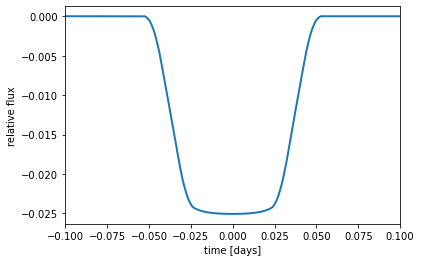

(array([-0.1       , -0.0997998 , -0.0995996 , -0.0993994 , -0.0991992 ,
        -0.098999  , -0.0987988 , -0.0985986 , -0.0983984 , -0.0981982 ,
        -0.097998  , -0.0977978 , -0.0975976 , -0.0973974 , -0.0971972 ,
        -0.096997  , -0.0967968 , -0.0965966 , -0.0963964 , -0.0961962 ,
        -0.095996  , -0.0957958 , -0.0955956 , -0.0953954 , -0.0951952 ,
        -0.09499499, -0.09479479, -0.09459459, -0.09439439, -0.09419419,
        -0.09399399, -0.09379379, -0.09359359, -0.09339339, -0.09319319,
        -0.09299299, -0.09279279, -0.09259259, -0.09239239, -0.09219219,
        -0.09199199, -0.09179179, -0.09159159, -0.09139139, -0.09119119,
        -0.09099099, -0.09079079, -0.09059059, -0.09039039, -0.09019019,
        -0.08998999, -0.08978979, -0.08958959, -0.08938939, -0.08918919,
        -0.08898899, -0.08878879, -0.08858859, -0.08838839, -0.08818819,
        -0.08798799, -0.08778779, -0.08758759, -0.08738739, -0.08718719,
        -0.08698699, -0.08678679, -0.08658659, -0.0

In [127]:
# ld_coeffs
generate_lightcurve(period=1, u=ld_coeffs[50],r=depth[50],texp=0.02, b=0, m_star=1,r_star=1)
# np.sqrt(planet['transmission'])

In [79]:
def semi_major_axis(per,M,R):
    per_s = per * 24 * 60 * 60 * u.s
    R_sun = R * 696340000 * u.m
    M_sun = M * 1.989e30 * u.kg

    a = ((per_s)**2 * G * M_sun/ (4 * math.pi**2))**(1./3) # in units of m
    a_radii = a / R_sun

    return a_radii

In [84]:
def generate_planet_params(ldc=[0.65, 0.28],limb_dark="quadratic", t0=0.0, p=1.0, R=1.0, M=1.0, i=0.5*math.pi, ecc=0, w=0):
    
    a = semi_major_axis(p,M,R)

    planet_params = {
                "t0": t0,
                "per": p,
                "a": a,
                "inc": i,
                "ecc": ecc,
                "w": w,
                "limb_dark": limb_dark,
                "u": ldc,
            }
    
    return planet_params

In [144]:
ldc = ld_coeffs
radii_ratio = depth
planet_params_inject = planet_params = {"limb_dark": ld_eqn, 'u':ld_coeffs} #generate_planet_params(ldc=ldc,limb_dark=ld_eqn)

In [145]:
r = SimulatedRainbow(
    signal_to_noise = 100, 
    dt = 1*u.minute,
    wavelength = wv_mean*u.micron,
    R = 50
    )

i = r.inject_transit(
    planet_radius = np.array(depth),
    planet_params = planet_params_inject
    )

In [146]:
b = i.bin(
    dw=0.1*u.micron, dt=10*u.minute
)


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


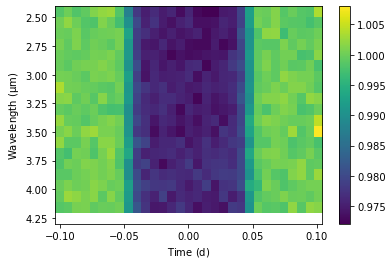

In [148]:
# r.imshow();
b.imshow();


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


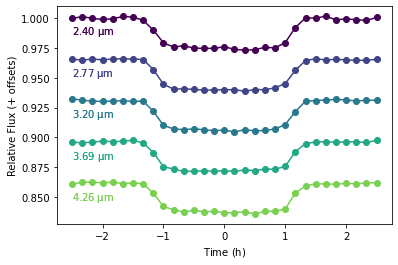

In [152]:
ax = b.bin(R=7).plot(plotkw=dict(alpha=0.1, markeredgecolor='none', linewidth=0))
b.bin(R=7, dt=10*u.minute).plot(ax=ax)

In [68]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [76]:
def rainbow_to_vector(r):
    # r: rainbow object
    rflux = r.fluxlike['flux']         # flux (MJy/sr)        : [n_wavelengths x n_integrations]
    rfluxe = r.fluxlike['uncertainty'] # flux error (MJy/sr)  : [n_wavelengths x n_integrations]
    rtime = r.timelike['time']         # time (BJD_TDB, days) : [n_integrations]
    rwavel = r.wavelike['wavelength']  # wavelength (microns) : [n_wavelengths]
    return rflux,rfluxe,rtime,rwavel

In [77]:
flux, flux_error, time, wavelength = rainbow_to_vector(b)
# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(time, wavelength.to_value())

In [85]:
# Convert this grid to columnar data expected by Altair
def alt_imshow(x,y,z,xlabel,ylabel,zlabel,ylog=True):
    source = pd.DataFrame({'x': x.ravel(),
                         'y': y.ravel(),
                         'z': z.ravel()})
    
    brush = alt.selection(type='interval', encodings=['y'])

    if ylog==False:
        spectrum = alt.Chart(source,width=280,height=230).mark_rect(clip=True,width=200/len(x),height=300/len(y)).encode(
            x=alt.X('x:Q',scale=alt.Scale(zero=False),title=xlabel),
            y=alt.Y('y:Q',scale=alt.Scale(zero=False,domain=[round(np.min(y),2),round(np.max(y),2)]),title=ylabel),
            color=alt.Color('z:Q',title=zlabel,scale=alt.Scale(zero=False,domain=[np.min(z),np.max(z)])),
            tooltip=['x','y','z']
        )
    else:
        spectrum = alt.Chart(source,width=280,height=230).mark_rect(clip=True,width=200/len(x),height=300/len(y)).encode(
            x=alt.X('x:Q',scale=alt.Scale(zero=False),title=xlabel),
            y=alt.Y('y:Q',scale=alt.Scale(zero=False,base=10,type='log'),title=ylabel),
            color=alt.Color('z:Q',title=zlabel,scale=alt.Scale(zero=False,domain=[np.min(z),np.max(z)])),
            tooltip=['x','y','z']
        )

    # gray background with selection
    background = spectrum.encode(
        color=alt.value('#ddd')
    ).add_selection(brush)
    
    # highlights on the transformed data
    highlight = spectrum.transform_filter(brush)
    
    spectrum_int = alt.layer(
    background,
    highlight,
    data=source
    )
    
    lightcurve = alt.Chart(source,width=280,height=230,title="Mean Lightcurve for Wavelength Range").mark_point(filled=True,clip=True, size=20,color='black').encode(
    x=alt.X('x:Q',
            scale=alt.Scale(zero=False),title=xlabel),
    y=alt.Y('mean(z):Q',
            scale=alt.Scale(zero=False,domain=[0.98,1.01]),title='Mean '+zlabel)
    ).transform_filter(
    brush
    )
    
    return spectrum_int | lightcurve
    

In [86]:
alt_imshow(x,y,flux,xlabel='Time (h)',ylabel='log10(wavelength)',zlabel='Flux',ylog=False).display()

alt.HConcatChart(...)

In [84]:
flux

array([[1.00027125, 0.99988489, 1.0010757 , ..., 0.99925322, 0.9990814 ,
        0.99961749],
       [1.00019394, 0.99981159, 1.00021982, ..., 0.99960017, 0.99968371,
        0.99947034],
       [1.00055984, 0.99997661, 1.00065062, ..., 1.00040892, 0.99974038,
        1.00040945],
       ...,
       [0.9998035 , 1.0003812 , 1.00038916, ..., 0.99948458, 1.00023045,
        0.99997976],
       [0.99872729, 0.99880069, 1.00122559, ..., 0.99856001, 1.00030666,
        0.99973256],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

# Testing out starry

In [73]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)
star.map[1] = 0.40
star.map[2] = 0.26

Compiling `render_ld`... Done.


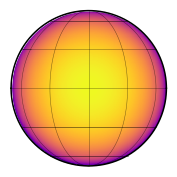

In [74]:
star.map.show()

In [75]:
planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=0,  # mass in solar masses
    r=0.1,  # radius in solar radii
    porb=1.0,  # orbital period in days
    prot=1.0,  # rotation period in days (synchronous)
    Omega=30,  # longitude of ascending node in degrees
    ecc=0.3,  # eccentricity
    w=30,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

Pre-computing some matrices... Done.


In [76]:
np.random.seed(123)
planet.map[1:, :] = 0.01 * np.random.randn(planet.map.Ny - 1)

Compiling `render`... Done.


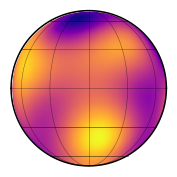

In [12]:
planet.map.show()

In [77]:
planet.theta0 = 180

In [19]:
# This routine performs gradient descent to try to find the global minimum of the map, and returns
# the latitude, longitude, and value of the intensity at the minimum.
planet.map.minimize()

ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_juyqzqby
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5hj3s427
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_1gvmo5i9
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_762uh7jx
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_q7_4p7km
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_zc67uxlb
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_wml06b0t
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5fz_jesf
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_75u51e8s
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_dm8qq3gc
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_qzgtmh_n
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_sqbwrt9x
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_mgwztuos
library imit=] is not found.

You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5v0o19fq
library imit=] is not found.


Exception: ('The following error happened while compiling the node', for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25}), '\n', 'Compilation failed (return status=1): In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. In file included from /usr/local/include/stdio.h:64:. /usr/local/include/_stdio.h:93:16: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         unsigned char   *_base;.                         ^. /usr/local/include/_stdio.h:93:16: note: insert \'_Nullable\' if the pointer may be null.         unsigned char   *_base;.                         ^.                           _Nullable . /usr/local/include/_stdio.h:93:16: note: insert \'_Nonnull\' if the pointer should never be null.         unsigned char   *_base;.                         ^.                           _Nonnull . /usr/local/include/_stdio.h:138:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                           ^. /usr/local/include/_stdio.h:138:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:138:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:138:40: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                                   ^. /usr/local/include/_stdio.h:138:40: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nullable. /usr/local/include/_stdio.h:138:40: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nonnull. /usr/local/include/_stdio.h:139:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^. /usr/local/include/_stdio.h:139:35: note: insert \'_Nullable\' if the pointer may be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:139:35: note: insert \'_Nonnull\' if the pointer should never be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                           ^. /usr/local/include/_stdio.h:140:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:140:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^. /usr/local/include/_stdio.h:140:46: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nullable. /usr/local/include/_stdio.h:140:46: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nonnull. /usr/local/include/_stdio.h:144:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^. /usr/local/include/_stdio.h:144:18: note: insert \'_Nullable\' if the pointer may be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nullable . /usr/local/include/_stdio.h:144:18: note: insert \'_Nonnull\' if the pointer should never be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. /usr/local/include/stdio.h:67:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern FILE *__stdinp;.             ^. /usr/local/include/stdio.h:67:13: note: insert \'_Nullable\' if the pointer may be null. extern FILE *__stdinp;.             ^.               _Nullable . /usr/local/include/stdio.h:67:13: note: insert \'_Nonnull\' if the pointer should never be null. extern FILE *__stdinp;.             ^.               _Nonnull . /usr/local/include/stdio.h:386:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                         ^. /usr/local/include/stdio.h:386:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:386:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:386:55: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                                       ^. /usr/local/include/stdio.h:386:55: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nullable. /usr/local/include/stdio.h:386:55: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nonnull. /usr/local/include/stdio.h:387:44: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^. /usr/local/include/stdio.h:387:44: note: insert \'_Nullable\' if the pointer may be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nullable. /usr/local/include/stdio.h:387:44: note: insert \'_Nonnull\' if the pointer should never be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nonnull. /usr/local/include/stdio.h:388:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *));.                                         ^. /usr/local/include/stdio.h:388:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:388:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:384:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. FILE    *funopen(const void *,.         ^. /usr/local/include/stdio.h:384:6: note: insert \'_Nullable\' if the pointer may be null. FILE    *funopen(const void *,.         ^.           _Nullable . /usr/local/include/stdio.h:384:6: note: insert \'_Nonnull\' if the pointer should never be null. FILE    *funopen(const void *,.         ^.           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:34:. /usr/local/include/stdlib.h:134:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   atof(const char *);.                          ^. /usr/local/include/stdlib.h:134:25: note: insert \'_Nullable\' if the pointer may be null. double   atof(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:134:25: note: insert \'_Nonnull\' if the pointer should never be null. double   atof(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:135:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      atoi(const char *);.                          ^. /usr/local/include/stdlib.h:135:22: note: insert \'_Nullable\' if the pointer may be null. int      atoi(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:135:22: note: insert \'_Nonnull\' if the pointer should never be null. int      atoi(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:136:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     atol(const char *);.                          ^. /usr/local/include/stdlib.h:136:23: note: insert \'_Nullable\' if the pointer may be null. long     atol(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:136:23: note: insert \'_Nonnull\' if the pointer should never be null. long     atol(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:139:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          atoll(const char *);.                           ^. /usr/local/include/stdlib.h:139:20: note: insert \'_Nullable\' if the pointer may be null.          atoll(const char *);.                           ^.                            _Nullable. /usr/local/include/stdlib.h:139:20: note: insert \'_Nonnull\' if the pointer should never be null.          atoll(const char *);.                           ^.                            _Nonnull. /usr/local/include/stdlib.h:141:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^. /usr/local/include/stdlib.h:141:26: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nullable . /usr/local/include/stdlib.h:141:26: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:141:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^. /usr/local/include/stdlib.h:141:45: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nullable . /usr/local/include/stdlib.h:141:45: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nonnull . /usr/local/include/stdlib.h:142:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^. /usr/local/include/stdlib.h:142:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:142:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:142:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^. /usr/local/include/stdlib.h:142:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:142:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:141:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:141:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:141:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:147:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.                            ^. /usr/local/include/stdlib.h:147:25: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:147:25: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:147:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.         ^. /usr/local/include/stdlib.h:147:6: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:147:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:156:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mblen(const char *__s, size_t __n);.                           ^. /usr/local/include/stdlib.h:156:23: note: insert \'_Nullable\' if the pointer may be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nullable . /usr/local/include/stdlib.h:156:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:157:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^. /usr/local/include/stdlib.h:157:26: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nullable. /usr/local/include/stdlib.h:157:26: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nonnull. /usr/local/include/stdlib.h:157:52: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^. /usr/local/include/stdlib.h:157:52: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nullable. /usr/local/include/stdlib.h:157:52: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nonnull. /usr/local/include/stdlib.h:158:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^. /usr/local/include/stdlib.h:158:21: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nullable. /usr/local/include/stdlib.h:158:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nonnull. /usr/local/include/stdlib.h:158:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^. /usr/local/include/stdlib.h:158:46: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nullable. /usr/local/include/stdlib.h:158:46: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nonnull. /usr/local/include/stdlib.h:160:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:160:18: note: insert \'_Nullable\' if the pointer may be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:160:18: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:161:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:161:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:161:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:161:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:161:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:161:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:165:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^. /usr/local/include/stdlib.h:165:27: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:165:27: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:165:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^. /usr/local/include/stdlib.h:165:35: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:165:35: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:165:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^. /usr/local/include/stdlib.h:165:36: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:165:36: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:166:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^. /usr/local/include/stdlib.h:166:26: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:166:26: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:166:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^. /usr/local/include/stdlib.h:166:34: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:166:34: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:166:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^. /usr/local/include/stdlib.h:166:35: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:166:35: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:167:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:167:25: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:167:25: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:167:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:167:38: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:167:38: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:167:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:167:39: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:167:39: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:169:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                             ^. /usr/local/include/stdlib.h:169:22: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:169:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:169:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                     ^. /usr/local/include/stdlib.h:169:30: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:169:30: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:169:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                      ^. /usr/local/include/stdlib.h:169:31: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:169:31: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:172:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:172:22: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:172:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:172:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:172:35: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:172:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:172:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:172:36: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:172:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:175:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:175:22: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:175:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:175:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:175:35: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:175:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:175:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:175:36: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:175:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:178:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                              ^. /usr/local/include/stdlib.h:178:23: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nullable . /usr/local/include/stdlib.h:178:23: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nonnull . /usr/local/include/stdlib.h:178:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:178:36: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nullable. /usr/local/include/stdlib.h:178:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nonnull. /usr/local/include/stdlib.h:178:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                            ^. /usr/local/include/stdlib.h:178:37: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nullable . /usr/local/include/stdlib.h:178:37: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nonnull . /usr/local/include/stdlib.h:190:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^. /usr/local/include/stdlib.h:190:24: note: insert \'_Nullable\' if the pointer may be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:190:24: note: insert \'_Nonnull\' if the pointer should never be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:194:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^. /usr/local/include/stdlib.h:194:23: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nullable. /usr/local/include/stdlib.h:194:23: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nonnull. /usr/local/include/stdlib.h:194:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^. /usr/local/include/stdlib.h:194:51: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nullable. /usr/local/include/stdlib.h:194:51: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nonnull. /usr/local/include/stdlib.h:195:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      wctomb(char *, wchar_t);.                      ^. /usr/local/include/stdlib.h:195:18: note: insert \'_Nullable\' if the pointer may be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:195:18: note: insert \'_Nonnull\' if the pointer should never be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:199:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     a64l(const char *);.                          ^. /usr/local/include/stdlib.h:199:23: note: insert \'_Nullable\' if the pointer may be null. long     a64l(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:199:23: note: insert \'_Nonnull\' if the pointer should never be null. long     a64l(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:201:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:201:29: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:201:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:201:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:201:46: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:201:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:201:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:201:6: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:201:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:202:31: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. double   erand48(unsigned short[3]);.                                ^. /usr/local/include/stdlib.h:202:31: note: insert \'_Nullable\' if the array parameter may be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:202:31: note: insert \'_Nonnull\' if the array parameter should never be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:203:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:203:29: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:203:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:203:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:203:46: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:203:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:203:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:203:6: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:203:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:204:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^. /usr/local/include/stdlib.h:204:30: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:204:30: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:204:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.         ^. /usr/local/include/stdlib.h:204:6: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:204:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:205:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                         ^. /usr/local/include/stdlib.h:205:21: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:205:21: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:205:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                          ^. /usr/local/include/stdlib.h:205:22: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:205:22: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:205:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                  ^. /usr/local/include/stdlib.h:205:30: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nullable. /usr/local/include/stdlib.h:205:30: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nonnull. /usr/local/include/stdlib.h:205:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                          ^. /usr/local/include/stdlib.h:205:38: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:205:38: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:205:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                  ^. /usr/local/include/stdlib.h:205:46: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:205:46: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:205:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                   ^. /usr/local/include/stdlib.h:205:47: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nullable. /usr/local/include/stdlib.h:205:47: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nonnull. /usr/local/include/stdlib.h:208:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^. /usr/local/include/stdlib.h:208:32: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:208:32: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:208:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^. /usr/local/include/stdlib.h:208:6: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nullable . /usr/local/include/stdlib.h:208:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nonnull . /usr/local/include/stdlib.h:212:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:212:29: note: insert \'_Nullable\' if the array parameter may be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:212:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:213:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *l64a(long);.         ^. /usr/local/include/stdlib.h:213:6: note: insert \'_Nullable\' if the pointer may be null. char    *l64a(long);.         ^.           _Nullable . /usr/local/include/stdlib.h:213:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *l64a(long);.         ^.           _Nonnull . /usr/local/include/stdlib.h:214:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. void     lcong48(unsigned short[7]);.                                ^. /usr/local/include/stdlib.h:214:29: note: insert \'_Nullable\' if the array parameter may be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:214:29: note: insert \'_Nonnull\' if the array parameter should never be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:216:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.                      ^. /usr/local/include/stdlib.h:216:19: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:216:19: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:216:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.         ^. /usr/local/include/stdlib.h:216:6: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:216:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:217:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mkstemp(char *);.                       ^. /usr/local/include/stdlib.h:217:19: note: insert \'_Nullable\' if the pointer may be null. int      mkstemp(char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:217:19: note: insert \'_Nonnull\' if the pointer should never be null. int      mkstemp(char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:219:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:219:29: note: insert \'_Nullable\' if the array parameter may be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:219:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:221:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ptsname(int);.         ^. /usr/local/include/stdlib.h:221:6: note: insert \'_Nullable\' if the pointer may be null. char    *ptsname(int);.         ^.           _Nullable . /usr/local/include/stdlib.h:221:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ptsname(int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:224:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^. /usr/local/include/stdlib.h:224:32: note: insert \'_Nullable\' if the pointer may be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:224:32: note: insert \'_Nonnull\' if the pointer should never be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:227:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^. /usr/local/include/stdlib.h:227:18: note: insert \'_Nullable\' if the pointer may be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:227:18: note: insert \'_Nonnull\' if the pointer should never be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:229:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^. /usr/local/include/stdlib.h:229:22: note: insert \'_Nullable\' if the pointer may be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nullable. /usr/local/include/stdlib.h:229:22: note: insert \'_Nonnull\' if the pointer should never be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:231:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^. /usr/local/include/stdlib.h:231:27: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:231:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:231:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^. /usr/local/include/stdlib.h:231:46: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:231:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:231:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^. /usr/local/include/stdlib.h:231:6: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nullable . /usr/local/include/stdlib.h:231:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nonnull . /usr/local/include/stdlib.h:236:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays].         *seed48(unsigned short[3]);.                               ^. /usr/local/include/stdlib.h:236:24: note: insert \'_Nullable\' if the array parameter may be null.         *seed48(unsigned short[3]);.                               ^.                                _Nullable . /usr/local/include/stdlib.h:236:24: note: insert \'_Nonnull\' if the array parameter should never be null.         *seed48(unsigned short[3]);.                               ^.                                _Nonnull . /usr/local/include/stdlib.h:236:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *seed48(unsigned short[3]);.         ^. /usr/local/include/stdlib.h:236:2: note: insert \'_Nullable\' if the pointer may be null.         *seed48(unsigned short[3]);.         ^.           _Nullable . /usr/local/include/stdlib.h:236:2: note: insert \'_Nonnull\' if the pointer should never be null.         *seed48(unsigned short[3]);.         ^.           _Nonnull . /usr/local/include/stdlib.h:237:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^. /usr/local/include/stdlib.h:237:24: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nullable. /usr/local/include/stdlib.h:237:24: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nonnull. /usr/local/include/stdlib.h:237:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^. /usr/local/include/stdlib.h:237:45: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:237:45: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:239:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^. /usr/local/include/stdlib.h:239:25: note: insert \'_Nullable\' if the pointer may be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:239:25: note: insert \'_Nonnull\' if the pointer should never be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:243:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.                              ^. /usr/local/include/stdlib.h:243:27: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:243:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:243:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.         ^. /usr/local/include/stdlib.h:243:6: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:243:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:252:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^. /usr/local/include/stdlib.h:252:26: note: insert \'_Nullable\' if the pointer may be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:252:26: note: insert \'_Nonnull\' if the pointer should never be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:265:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^. /usr/local/include/stdlib.h:265:42: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nullable. /usr/local/include/stdlib.h:265:42: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nonnull. /usr/local/include/stdlib.h:270:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^. /usr/local/include/stdlib.h:270:27: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:270:27: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:276:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^. /usr/local/include/stdlib.h:276:28: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nullable . /usr/local/include/stdlib.h:276:28: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nonnull . /usr/local/include/stdlib.h:276:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^. /usr/local/include/stdlib.h:276:47: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nullable . /usr/local/include/stdlib.h:276:47: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nonnull . /usr/local/include/stdlib.h:277:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^. /usr/local/include/stdlib.h:277:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:277:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:277:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^. /usr/local/include/stdlib.h:277:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:277:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:276:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:276:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:276:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:281:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                       ^. /usr/local/include/stdlib.h:281:20: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:281:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:281:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                                     ^. /usr/local/include/stdlib.h:281:34: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:281:34: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:281:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.         ^. /usr/local/include/stdlib.h:281:6: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nullable . /usr/local/include/stdlib.h:281:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:283:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                       ^. /usr/local/include/stdlib.h:283:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:283:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:283:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                        ^. /usr/local/include/stdlib.h:283:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:283:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:283:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                ^. /usr/local/include/stdlib.h:283:28: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nullable. /usr/local/include/stdlib.h:283:28: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nonnull. /usr/local/include/stdlib.h:283:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                 ^. /usr/local/include/stdlib.h:283:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:283:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:283:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                               ^. /usr/local/include/stdlib.h:283:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:283:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:284:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                         ^. /usr/local/include/stdlib.h:284:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:284:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:284:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                          ^. /usr/local/include/stdlib.h:284:22: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:284:22: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:284:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                  ^. /usr/local/include/stdlib.h:284:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:284:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:284:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                   ^. /usr/local/include/stdlib.h:284:31: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:284:31: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:285:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                               ^. /usr/local/include/stdlib.h:285:27: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:285:27: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:285:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                                             ^. /usr/local/include/stdlib.h:285:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:285:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:286:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                        ^. /usr/local/include/stdlib.h:286:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:286:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:286:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                         ^. /usr/local/include/stdlib.h:286:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:286:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:286:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                 ^. /usr/local/include/stdlib.h:286:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:286:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:286:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                  ^. /usr/local/include/stdlib.h:286:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:286:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:287:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                       ^. /usr/local/include/stdlib.h:287:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:287:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:287:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                     ^. /usr/local/include/stdlib.h:287:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:287:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:287:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                             ^. /usr/local/include/stdlib.h:287:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:287:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:288:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetset(const char *);.                             ^. /usr/local/include/stdlib.h:288:25: note: insert \'_Nullable\' if the pointer may be null. int      cgetset(const char *);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:288:25: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetset(const char *);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:289:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                       ^. /usr/local/include/stdlib.h:289:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:289:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:289:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                     ^. /usr/local/include/stdlib.h:289:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:289:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:289:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                             ^. /usr/local/include/stdlib.h:289:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:289:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:289:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:289:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:289:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                        ^. /usr/local/include/stdlib.h:290:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:290:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:290:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                      ^. /usr/local/include/stdlib.h:290:34: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:290:34: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:290:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:290:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:290:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                               ^. /usr/local/include/stdlib.h:290:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:290:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:293:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname(dev_t, mode_t);.         ^. /usr/local/include/stdlib.h:293:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname(dev_t, mode_t);.         ^.           _Nullable . /usr/local/include/stdlib.h:293:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname(dev_t, mode_t);.         ^.           _Nonnull . /usr/local/include/stdlib.h:294:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^. /usr/local/include/stdlib.h:294:37: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nullable . /usr/local/include/stdlib.h:294:37: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nonnull . /usr/local/include/stdlib.h:294:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^. /usr/local/include/stdlib.h:294:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nullable . /usr/local/include/stdlib.h:294:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nonnull . /usr/local/include/stdlib.h:295:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                       ^. /usr/local/include/stdlib.h:295:20: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:295:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:295:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                               ^. /usr/local/include/stdlib.h:295:28: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:295:28: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:295:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.         ^. /usr/local/include/stdlib.h:295:6: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.         ^.           _Nullable . /usr/local/include/stdlib.h:295:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:296:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. int      getloadavg(double [], int);.                            ^. /usr/local/include/stdlib.h:296:24: note: insert \'_Nullable\' if the array parameter may be null. int      getloadavg(double [], int);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:296:24: note: insert \'_Nonnull\' if the array parameter should never be null. int      getloadavg(double [], int);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:298:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *getprogname(void);.         ^. /usr/local/include/stdlib.h:298:2: note: insert \'_Nullable\' if the pointer may be null.         *getprogname(void);.         ^.           _Nullable . /usr/local/include/stdlib.h:298:2: note: insert \'_Nonnull\' if the pointer should never be null.         *getprogname(void);.         ^.           _Nonnull . /usr/local/include/stdlib.h:299:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setprogname(const char *);.                                 ^. /usr/local/include/stdlib.h:299:30: note: insert \'_Nullable\' if the pointer may be null. void     setprogname(const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:299:30: note: insert \'_Nonnull\' if the pointer should never be null. void     setprogname(const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:309:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^. /usr/local/include/stdlib.h:309:20: note: insert \'_Nullable\' if the pointer may be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nullable . /usr/local/include/stdlib.h:309:20: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:310:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:310:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:310:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:310:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:310:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:310:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:312:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^. /usr/local/include/stdlib.h:312:22: note: insert \'_Nullable\' if the pointer may be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nullable . /usr/local/include/stdlib.h:312:22: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nonnull . /usr/local/include/stdlib.h:313:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:313:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:313:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:313:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:313:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:313:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:316:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^. /usr/local/include/stdlib.h:316:21: note: insert \'_Nullable\' if the pointer may be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nullable . /usr/local/include/stdlib.h:316:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nonnull . /usr/local/include/stdlib.h:317:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:317:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:317:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:317:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:317:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:317:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:319:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^. /usr/local/include/stdlib.h:319:23: note: insert \'_Nullable\' if the pointer may be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nullable . /usr/local/include/stdlib.h:319:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:320:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:320:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:320:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:320:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:320:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:320:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:323:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:323:18: note: insert \'_Nullable\' if the pointer may be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:323:18: note: insert \'_Nonnull\' if the pointer should never be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:324:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^. /usr/local/include/stdlib.h:324:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:324:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:324:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^. /usr/local/include/stdlib.h:324:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:324:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:327:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:327:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:327:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:328:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:328:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:328:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:328:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:328:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:328:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:331:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:331:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:331:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:331:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:331:64: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:331:64: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:332:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^. /usr/local/include/stdlib.h:332:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:332:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:332:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^. /usr/local/include/stdlib.h:332:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:332:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:332:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^. /usr/local/include/stdlib.h:332:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:332:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:335:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:335:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:335:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:336:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:336:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:336:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:336:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:336:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:336:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:339:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:339:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:339:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:339:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:339:64: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:339:64: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:340:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^. /usr/local/include/stdlib.h:340:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:340:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:340:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^. /usr/local/include/stdlib.h:340:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:340:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:340:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^. /usr/local/include/stdlib.h:340:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:340:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:341:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^. /usr/local/include/stdlib.h:341:36: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nullable. /usr/local/include/stdlib.h:341:36: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nonnull. /usr/local/include/stdlib.h:341:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:341:37: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nullable . /usr/local/include/stdlib.h:341:37: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nonnull . /usr/local/include/stdlib.h:341:77: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^. /usr/local/include/stdlib.h:341:77: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nullable . /usr/local/include/stdlib.h:341:77: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nonnull . /usr/local/include/stdlib.h:343:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     rpmatch(const char *).                            ^. /usr/local/include/stdlib.h:343:24: note: insert \'_Nullable\' if the pointer may be null. int     rpmatch(const char *).                            ^.                             _Nullable. /usr/local/include/stdlib.h:343:24: note: insert \'_Nonnull\' if the pointer should never be null. int     rpmatch(const char *).                            ^.                             _Nonnull. /usr/local/include/stdlib.h:345:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:345:37: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:345:37: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:345:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^. /usr/local/include/stdlib.h:345:38: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:345:38: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:345:78: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^. /usr/local/include/stdlib.h:345:78: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nullable . /usr/local/include/stdlib.h:345:78: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nonnull . /usr/local/include/stdlib.h:349:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^. /usr/local/include/stdlib.h:349:21: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nullable . /usr/local/include/stdlib.h:349:21: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:349:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^. /usr/local/include/stdlib.h:349:6: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nullable . /usr/local/include/stdlib.h:349:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nonnull . /usr/local/include/stdlib.h:351:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^. /usr/local/include/stdlib.h:351:22: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nullable . /usr/local/include/stdlib.h:351:22: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nonnull . /usr/local/include/stdlib.h:351:84: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^. /usr/local/include/stdlib.h:351:84: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nullable. /usr/local/include/stdlib.h:351:84: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nonnull. /usr/local/include/stdlib.h:351:85: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^. /usr/local/include/stdlib.h:351:85: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nullable . /usr/local/include/stdlib.h:351:85: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nonnull . /usr/local/include/stdlib.h:355:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:355:21: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:355:21: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:355:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:355:34: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:355:34: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:355:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:355:35: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:355:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:357:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:357:22: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:357:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:357:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:357:35: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:357:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:357:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:357:36: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:357:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:359:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^. /usr/local/include/stdlib.h:359:13: note: insert \'_Nullable\' if the pointer may be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nullable . /usr/local/include/stdlib.h:359:13: note: insert \'_Nonnull\' if the pointer should never be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:145:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/pythread.h:128:. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:610:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/npy_interrupt.h:23:. /usr/local/include/signal.h:69:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern __const char *__const sys_signame[NSIG];.                     ^. /usr/local/include/signal.h:69:21: note: insert \'_Nullable\' if the pointer may be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nullable . /usr/local/include/signal.h:69:21: note: insert \'_Nonnull\' if the pointer should never be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nonnull . /usr/local/include/signal.h:82:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_kill(pthread_t, int);.                      ^. /usr/local/include/signal.h:82:18: note: insert \'_Nullable\' if the pointer may be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nullable . /usr/local/include/signal.h:82:18: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nonnull . /usr/local/include/signal.h:83:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^. /usr/local/include/signal.h:83:41: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nullable. /usr/local/include/signal.h:83:41: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nonnull. /usr/local/include/signal.h:83:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^. /usr/local/include/signal.h:83:53: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nullable. /usr/local/include/signal.h:83:53: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nonnull. /usr/local/include/signal.h:84:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaction(int, const struct sigaction * __restrict,.                                               ^. /usr/local/include/signal.h:84:43: note: insert \'_Nullable\' if the pointer may be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nullable. /usr/local/include/signal.h:84:43: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nonnull. /usr/local/include/signal.h:85:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             struct sigaction * __restrict);.                              ^. /usr/local/include/signal.h:85:23: note: insert \'_Nullable\' if the pointer may be null.             struct sigaction * __restrict);.                              ^.                                _Nullable. /usr/local/include/signal.h:85:23: note: insert \'_Nonnull\' if the pointer should never be null.             struct sigaction * __restrict);.                              ^.                                _Nonnull. /usr/local/include/signal.h:86:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaddset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:86:24: note: insert \'_Nullable\' if the pointer may be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:86:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:87:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^. /usr/local/include/signal.h:87:31: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nullable. /usr/local/include/signal.h:87:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nonnull. /usr/local/include/signal.h:87:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^. /usr/local/include/signal.h:87:53: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nullable. /usr/local/include/signal.h:87:53: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nonnull. /usr/local/include/signal.h:88:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigdelset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:88:24: note: insert \'_Nullable\' if the pointer may be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:88:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:89:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigemptyset(sigset_t *);.                              ^. /usr/local/include/signal.h:89:26: note: insert \'_Nullable\' if the pointer may be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nullable. /usr/local/include/signal.h:89:26: note: insert \'_Nonnull\' if the pointer should never be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nonnull. /usr/local/include/signal.h:90:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigfillset(sigset_t *);.                             ^. /usr/local/include/signal.h:90:25: note: insert \'_Nullable\' if the pointer may be null. int     sigfillset(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:90:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigfillset(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:94:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigismember(const sigset_t *, int);.                                    ^. /usr/local/include/signal.h:94:32: note: insert \'_Nullable\' if the pointer may be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nullable. /usr/local/include/signal.h:94:32: note: insert \'_Nonnull\' if the pointer should never be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nonnull. /usr/local/include/signal.h:96:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigpending(sigset_t *);.                             ^. /usr/local/include/signal.h:96:25: note: insert \'_Nullable\' if the pointer may be null. int     sigpending(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:96:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigpending(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:97:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^. /usr/local/include/signal.h:97:37: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nullable. /usr/local/include/signal.h:97:37: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nonnull. /usr/local/include/signal.h:97:60: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^. /usr/local/include/signal.h:97:60: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nullable. /usr/local/include/signal.h:97:60: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nonnull. /usr/local/include/signal.h:100:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^. /usr/local/include/signal.h:100:31: note: insert \'_Nullable\' if the pointer may be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:100:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:101:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^. /usr/local/include/signal.h:101:28: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nullable. /usr/local/include/signal.h:101:28: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nonnull. /usr/local/include/signal.h:101:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^. /usr/local/include/signal.h:101:46: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nullable. /usr/local/include/signal.h:101:46: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nonnull. /usr/local/include/signal.h:103:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    psignal(unsigned int, const char *);.                                          ^. /usr/local/include/signal.h:103:39: note: insert \'_Nullable\' if the pointer may be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nullable. /usr/local/include/signal.h:103:39: note: insert \'_Nonnull\' if the pointer should never be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nonnull. /usr/local/include/signal.h:106:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^. /usr/local/include/signal.h:106:31: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:106:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:106:48: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^. /usr/local/include/signal.h:106:48: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nullable. /usr/local/include/signal.h:106:48: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nonnull. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:317:9: error: no member named \'signbit\' in the global namespace; did you mean \'sigwait\'?. using ::signbit;.       ~~^. /usr/local/include/signal.h:101:5: note: \'sigwait\' declared here. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:318:9: error: no member named \'fpclassify\' in the global namespace. using ::fpclassify;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:319:9: error: no member named \'isfinite\' in the global namespace; did you mean \'finite\'?. using ::isfinite;.       ~~^. /usr/local/include/math.h:752:12: note: \'finite\' declared here. extern int finite(double).            ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:320:9: error: no member named \'isinf\' in the global namespace. using ::isinf;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:321:9: error: no member named \'isnan\' in the global namespace. using ::isnan;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:322:9: error: no member named \'isnormal\' in the global namespace. using ::isnormal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:323:9: error: no member named \'isgreater\' in the global namespace. using ::isgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:324:9: error: no member named \'isgreaterequal\' in the global namespace. using ::isgreaterequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:325:9: error: no member named \'isless\' in the global namespace. using ::isless;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:326:9: error: no member named \'islessequal\' in the global namespace. using ::islessequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:327:9: error: no member named \'islessgreater\' in the global namespace. using ::islessgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:328:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:329:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:26: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                          ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:60: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                                                            ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:18: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:50: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                                                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:646:17: error: no template named \'numeric_limits\'.   static_assert(numeric_limits<_FloatT>::radix == 2, "FloatT has incorrect radix");.                 ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:649:25: error: no template named \'numeric_limits\'.   return _FloatBigger ? numeric_limits<_IntT>::max() :  (numeric_limits<_IntT>::max() >> _Bits << _Bits);.                         ^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 219 warnings and 20 errors generated.. ')

In [78]:
system = starry.System(star, planet)

In [86]:
%%time
time = np.linspace(-0.25, 3.25, 10000)
flux_system = system.flux(time)

CPU times: user 330 ms, sys: 215 ms, total: 545 ms
Wall time: 593 ms


TypeError: object of type 'TensorVariable' has no len()

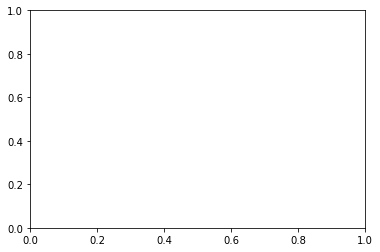

In [87]:
plt.plot(time, flux_system)
plt.xlabel("time [days]")
plt.ylabel("system flux");

In [39]:
planet.r = 0.33
system.show(t=np.linspace(0, 1, 50), window_pad=4, figsize=(8, 8))

Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.


# Generate Simulated Lightcurve with Exoplanet 

class exoplanet.orbits.KeplerianOrbit(period, a, t0, t_periastron,
incl, b, duration, ecc, omega, sin_omega, cos_omega, Omega, m_planet,
m_star, r_star, rho_star, ror, model)

In [113]:
def generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.02, b=0, m_star=1,r_star=1):
    """
    Function to generate lightcurve using Exoplanet

    Parameters
    ----------
    period : int, float
        Orbital period of planet
    u : list, array
        Quadratic Limb-darkening coefficients
    r : int, float
        Radius of planet in Solar radii
    texp : int, float
        Exposure time of lightcurve
    b : int, float
        Impact parameter
    m_star : int, float
        Mass of star in Solar masses
    r_star : int, float
        Radius of star in Solar radii
        

    Returns
    -------
    t : 1-D array
        Time array for the lightcurve
    lightcurve : 1-D array
        1-D flux array 
    """

    # The light curve calculation requires an orbit
    orbit = xo.orbits.KeplerianOrbit(period=period,b=b,m_star=m_star, r_star=r_star)

    # Compute a limb-darkened light curve using starry
    t = np.linspace(-0.1, 0.1, 1000)
    light_curve = (
        xo.LimbDarkLightCurve(*u)
        .get_light_curve(orbit=orbit, r=r, t=t, texp=texp)
        .eval()
    )
    # Note: the `eval` is needed because this is using Theano in
    # the background

    plt.plot(t, light_curve, color="C0", lw=2)
    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    _ = plt.xlim(t.min(), t.max())
    plt.show()
    plt.close()
    
    return t, light_curve

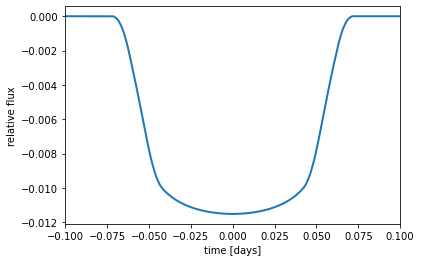

In [68]:
t,lc = generate_lightcurve()

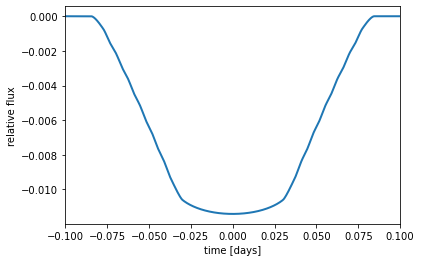

In [69]:
t,lc = generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.05)

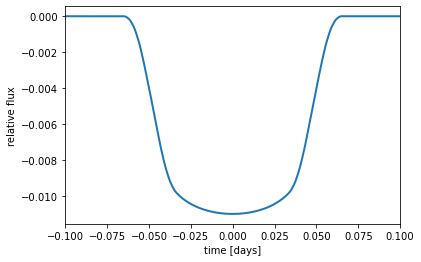

In [70]:
t,lc = generate_lightcurve(b=0.5)